# Pollution peaks
Author: Aurélie Daviaud

* Language: R
* Methods : Time series (regression) (ARIMA, neural network)

## Table of Contents
1 Data preparation<br>
...1.1 Preparation of weather data<br>
...1.2 Create dataframe<br>
......1.2.1 Load data<br>
......1.2.2 Perform date transformations<br>
......1.2.3 Calculate daily averages of weather data<br>
......1.2.4 Load dataMeteo and give proper class to dates and proper names<br>
......1.2.5 Load holidays' dates<br>
...1.3 Feature engineering<br>
......1.3.1 Weekdays<br>
......1.3.2 Holidays<br>
......1.3.3 Traffic (days when people go to and return from holidays)<br>
......1.3.4 Pollution<br>
2 Split the dataset<br>
3 Exploratory data analysis<br>
...3.1 Check missing values<br>
...3.2 Decomposition of the time series<br>
......3.2.1 Check plots<br>
......3.2.2 Create a time series object<br>
......3.2.3 Decomposition of the series<br>
...3.3 Visualize relationships<br>
......3.3.1 Check correlations among variables<br>
......3.3.2 Temperature<br>
......3.3.3 Cloudiness<br>
......3.3.4 Wind<br>
......3.3.5 Rain<br>
......3.3.6 Traffic<br>
4 Regularized linear regression (coming soon)<br>
5 ARIMA<br>
...5.1 Preliminar checks<br>
......5.1.1 Stationarity<br>
......5.1.2 Plot ACF/PACF charts<br>
......5.1.3 Differencing the original non-stationary data<br>
...5.2 Build models<br>
......5.2.1 Quick and dirty<br>
......5.2.2 Add seasonality (with Fourier terms)<br>
...5.3 Add regressors<br>
6 Artificial Neural Networks (feed forward network)<br>
...6.1 Build models<br>
......6.1.1 Quick and dirty<br>
......6.1.2 Add seasonality (with Fourier terms)<br>
......6.1.3 Add regressors<br>
7 Compare models' performances<br>
8 Walk Forward Validation<br>
9 Going further

**Context** <br>
In this project, we will try to **predict pollution peaks** one week ahead.<br>
The dataset includes data from the 01/01/2005 to the 31/12/2016 (12 years).

**Open Data** <br>
Air quality at Nantes: http://data.nantes.fr/donnees/detail/indice-atmo-journalier-a-nantes/ <br>
Holidays (as a proxi for traffic)): http://www.education.gouv.fr/cid197/les-archives-calendrier-scolaire-partir-1960.html#Zones <br>
Weather: we will use the code from https://github.com/boupetch/meteofrance-synop-omm (see below) to retrieve open data from
https://donneespubliques.meteofrance.fr/?fond=produit&id_produit=90&id_rubrique=32

In [32]:
# Load libraries
library(RCurl)        # curlPerform()
library(lubridate)    # month()
library(dplyr)        # %>%
library(dummies)      # dummy.data.frame()
library(zoo)          # lag(), coredata()
library(polycor)      # hetcor()
library(ggplot2)      # ggplot()
library(caret)        # train(), trainControl(), resamples(), varImp()
library(car)          # vif()
library(plyr)         # revalue()
library(rpart.plot)
library(tseries)
library(forecast)
library(TSA)          # periodogram()
library(data.table)   # data.table()
library(ggforce)      # visualization tools
library(plotly)       # interactive visualizations
library(grid)         # visualizations
library(animation)    # gif
library(magick)       # gif
library(scales)       # ggplot dates

In [33]:
# Set working directory
setwd("./")

# 1 Data preparation

## 1.1 Preparation of weather data

We can use the code from https://github.com/boupetch/meteofrance-synop-omm (see below)to retrieve open data from https://donneespubliques.meteofrance.fr/?fond=produit&id_produit=90&id_rubrique=32

In [ ]:
## Stations list

filename <- "postesSynop.csv"

if(!file.exists(filename)){
  f = CFILE(filename, mode="wb")
  curlPerform(url = "https://donneespubliques.meteofrance.fr/donnees_libres/Txt/Synop/postesSynop.csv", writedata = f@ref)
  close(f)
}
synopStations <- read.csv2(filename)


## Weather data

meteoData <- list()

date <- as.Date("20041201",format="%Y%m%d")
lastdate <- as.Date("20170101",format="%Y%m%d")

while(format(date,"%Y%m") < format(lastdate,"%Y%m")){
  
  month(date) <- month(date) + 1
  
  #Download file
  filename <- gsub(" ", "",paste ("synop.",format(date,"%Y%m"),".csv.gz"))
  
  if(!file.exists(filename) | (format(date,"%Y%m") == format(Sys.Date(),"%Y%m"))){
    f = CFILE(filename, mode="wb")
    curlPerform(url = gsub(" ", "",paste("https://donneespubliques.meteofrance.fr/donnees_libres/Txt/Synop/Archive/synop.",format(date,"%Y%m"),".csv.gz")), writedata = f@ref)
    close(f)
  }
  
  meteoData[[format(date,"%Y%m")]] <- read.csv2(gzfile(filename))
  
  print(format(date,"%Y%m"))
}



## Perform date transformations

for (name in names(meteoData)) {

  #Date characters
  meteoData[[name]]$date_string <- format(meteoData[[name]]$date, scientific = FALSE)
  meteoData[[name]]$date_string <- as.character(meteoData[[name]]$date_string)
  
  #Year
  meteoData[[name]]$year <- as.numeric(substr(meteoData[[name]]$date_string, 1, 4))
  
  #Month
  meteoData[[name]]$month <- as.numeric(substr(meteoData[[name]]$date_string, 5, 6))
  
  #Day
  meteoData[[name]]$day <- as.numeric(substr(meteoData[[name]]$date_string, 7, 8))
  
  #Hour
  meteoData[[name]]$hour <- as.numeric(substr(meteoData[[name]]$date_string, 9, 10))

}


## Export to CSV

exportFilename <- "synop.csv"

file.remove(exportFilename)

count <- 0
for (name in names(meteoData)) {
  print(name)
  if(count == 0){
    write.table(meteoData[[name]], file = exportFilename,sep = ";",row.names = FALSE,col.names = TRUE)
  } else{
    write.table(meteoData[[name]], file = exportFilename, append=TRUE,sep = ";",row.names = FALSE,col.names = FALSE)
  }
  count <- count+1
}

## 1.2 Create dataframe

### 1.2.1 Load data

In [239]:
meteo <- read.csv("synop.csv", sep=";", header=TRUE, na.strings = "mq")
meteoNantes <- meteo[meteo$numer_sta==7222,]
meteoNantes <- meteoNantes[,-1]

airqual <- read.csv("QualiteAirNantes.csv", sep=",", header=TRUE)
airqual <- airqual[,-1]

### 1.2.2 Perform date transformations

In [240]:
meteoNantes$date2 <- paste(meteoNantes$day, meteoNantes$mont, meteoNantes$year, sep="/")
meteoNantes$date3 <- as.Date(meteoNantes$date2, format="%d/%m/%Y")
meteoNantes$date <- meteoNantes$date3

airqual$DATE <- as.Date(airqual$DATE, format="%d/%m/%Y")
airqual$year <- as.numeric(format(airqual$DATE, "%Y"))
airqual$month <- as.numeric(format(airqual$DATE, "%m"))
#airqual$day <- as.numeric(format(airqual$DATE, "%d"))

### 1.2.3 Calculate daily averages of weather data

In [241]:
meteoNantes$tempC <- as.numeric(as.character(meteoNantes$t))-273.15

all <- airqual

varnames <- c("ff", "tempC", "u", "n", "pres", "rafper", "rr24")

for (var in varnames) {
	avgDaily <- tapply(as.numeric(as.character(meteoNantes[,var])), meteoNantes$date, mean, na.rm=TRUE)
	avgDaily2 <- as.data.frame(avgDaily)
	colnames(avgDaily2) <- var
	avgDaily2$DATE <- row.names(avgDaily2)
	avgDaily2$DATE <- as.Date(avgDaily2$DATE, format="%Y-%m-%d")

	# Join tables by DATE (left outer join)
	all <- merge(all, avgDaily2, by="DATE", all.x=TRUE)
}

## Save dataframe
write.table(all, file="dataMeteo.csv", sep=",", row.names=FALSE)

### 1.2.4 Load dataMeteo and give proper class to dates and proper names

In [242]:
dat <- read.csv("dataMeteo.csv", sep=",", header=TRUE)

In [243]:
dat$DATE <- as.Date(dat$DATE, format="%Y-%m-%d")
names(dat)[names(dat) == "ff"] <- "wind"
names(dat)[names(dat) == "u"] <- "humidity"
names(dat)[names(dat) == "n"] <- "cloud"
names(dat)[names(dat) == "rr24"] <- "rain24"
dat$CODE_COULEUR <- NULL

In [244]:
str(dat)

'data.frame':	4383 obs. of  15 variables:
 $ DATE                         : Date, format: "2005-01-01" "2005-01-02" ...
 $ INDICE_ATMO                  : int  3 3 4 3 3 3 3 3 3 3 ...
 $ SOUS_INDICE_OZONE            : int  3 3 2 2 3 3 3 3 3 3 ...
 $ SOUS_INDICE_PARTICULES_FINES : int  1 2 3 2 1 2 1 3 2 2 ...
 $ SOUS_INDICE_DIOXYDE_D_AZOTE  : int  1 3 4 3 1 3 2 3 1 2 ...
 $ SOUS_INDICE_DIOXYDE_DE_SOUFRE: int  1 1 1 1 1 1 1 1 1 1 ...
 $ year                         : int  2005 2005 2005 2005 2005 2005 2005 2005 2005 2005 ...
 $ month                        : int  1 1 1 1 1 1 1 1 1 1 ...
 $ wind                         : num  4.89 3.34 1.41 2.96 5.26 ...
 $ tempC                        : num  11.2 7.88 3.14 3.76 10.81 ...
 $ humidity                     : num  96.9 80.8 91.6 91.5 95.1 ...
 $ cloud                        : num  97.5 61.67 8.57 60 98.75 ...
 $ pres                         : num  102558 102985 103631 102971 102706 ...
 $ rafper                       : num  7.9 5.64 2.73 4.22 

### 1.2.5 Load holidays' dates

In [245]:
cal <- read.csv("calScol.csv", sep=",", header=TRUE, row.names = NULL)
cal$first <- as.Date(cal$first, format="%d/%m/%Y")    # first day of holidays
cal$last <- as.Date(cal$last, format="%d/%m/%Y")-1    # the official last day of holidays is actually the first day of school

In [246]:
str(cal)

'data.frame':	64 obs. of  3 variables:
 $ Vacances: Factor w/ 5 levels "Eté","Hiver",..: 5 3 2 4 1 5 3 2 4 1 ...
 $ first   : Date, format: "2004-10-23" "2004-12-18" ...
 $ last    : Date, format: "2004-11-03" "2005-01-02" ...


## 1.3 Feature engineering

### 1.3.1 Weekdays

In [247]:
dat$weekday <- weekdays(dat$DATE)

Now, we can create dummy variables for 'weekdays' and 'month'.

In [248]:
dat <- dummy.data.frame(dat, names= c("weekday", "month") , sep = "_")

In [249]:
head(dat,3)

DATE,INDICE_ATMO,SOUS_INDICE_OZONE,SOUS_INDICE_PARTICULES_FINES,SOUS_INDICE_DIOXYDE_D_AZOTE,SOUS_INDICE_DIOXYDE_DE_SOUFRE,year,month_1,month_2,month_3,...,pres,rafper,rain24,weekday_dimanche,weekday_jeudi,weekday_lundi,weekday_mardi,weekday_mercredi,weekday_samedi,weekday_vendredi
2005-01-01,3,3,1,1,1,2005,1,0,0,...,102557.5,7.9000,0.8,0,0,0,0,0,1,0
2005-01-02,3,3,2,3,1,2005,1,0,0,...,102985.0,5.6375,1.0,1,0,0,0,0,0,0
2005-01-03,4,2,3,4,1,2005,1,0,0,...,103631.2,2.7250,0.0,0,0,1,0,0,0,0


### 1.3.2 Holidays

In [250]:
# Generate all dates between the first and last day of holidays
cal2 <- cal %>% rowwise() %>% 
   do(data.frame(.[1], date = as.Date(as.Date(.$first):as.Date(.$last), origin="1970-01-01")))
cal2 <- as.data.frame(cal2)

dat$holidays <- ifelse(dat$DATE %in% cal2$date, 1, 0)

### 1.3.3 Traffic (days when people go to and return from holidays)

We do not have traffic data but we can use a **proxi** by assuming that days when people go to and return from holidays are likely to face a lot of traffic.

In [251]:
cal$befFirst <- as.Date(cal$first, format="%d/%m/%Y")-1
cal$befLast <- as.Date(cal$last, format="%d/%m/%Y")-1

dat$goHolidays <- as.numeric(dat$DATE %in% cal$first | dat$DATE %in% cal$befFirst)
dat$returnHolidays <- as.numeric(dat$DATE %in% cal$last | dat$DATE %in% cal$befLast)
dat$goReturnHolidays <- as.numeric(dat$goHolidays==1 | dat$returnHolidays==1)

### 1.3.4 Pollution

The pollution is very high when the ATMO index is from 8 to 10. Then we use the expression "pollution peak".

In [252]:
dat$polPeak <- ifelse(dat$INDICE_ATMO >= 8, 1, 0)   # with an ATMO index from 8, the air quality is considered as bad to very bad
                                                    # this is a very rare event

Let's remove some unnecessary variables.

In [253]:
dat$SOUS_INDICE_OZONE <- NULL
dat$SOUS_INDICE_PARTICULES_FINES <- NULL
dat$SOUS_INDICE_DIOXYDE_D_AZOTE <- NULL
dat$SOUS_INDICE_DIOXYDE_DE_SOUFRE <- NULL
dat$goHolidays <- NULL
dat$returnHolidays <- NULL

In [254]:
str(dat)

'data.frame':	4383 obs. of  32 variables:
 $ DATE            : Date, format: "2005-01-01" "2005-01-02" ...
 $ INDICE_ATMO     : int  3 3 4 3 3 3 3 3 3 3 ...
 $ year            : int  2005 2005 2005 2005 2005 2005 2005 2005 2005 2005 ...
 $ month_1         : int  1 1 1 1 1 1 1 1 1 1 ...
 $ month_2         : int  0 0 0 0 0 0 0 0 0 0 ...
 $ month_3         : int  0 0 0 0 0 0 0 0 0 0 ...
 $ month_4         : int  0 0 0 0 0 0 0 0 0 0 ...
 $ month_5         : int  0 0 0 0 0 0 0 0 0 0 ...
 $ month_6         : int  0 0 0 0 0 0 0 0 0 0 ...
 $ month_7         : int  0 0 0 0 0 0 0 0 0 0 ...
 $ month_8         : int  0 0 0 0 0 0 0 0 0 0 ...
 $ month_9         : int  0 0 0 0 0 0 0 0 0 0 ...
 $ month_10        : int  0 0 0 0 0 0 0 0 0 0 ...
 $ month_11        : int  0 0 0 0 0 0 0 0 0 0 ...
 $ month_12        : int  0 0 0 0 0 0 0 0 0 0 ...
 $ wind            : num  4.89 3.34 1.41 2.96 5.26 ...
 $ tempC           : num  11.2 7.88 3.14 3.76 10.81 ...
 $ humidity        : num  96.9 80.8 91.6 91.5 95.1 .

Save new dataset

In [255]:
write.table(dat, file="dataMeteo2.csv", sep=",", row.names=FALSE)

# 2 Split the dataset

In [256]:
# Load data and give a  class to dates
dat <- read.csv("dataMeteo2.csv", sep=",", header=TRUE)
dat$DATE <- as.Date(dat$DATE, format="%Y-%m-%d")

In [257]:
# Check data
str(dat)

'data.frame':	4383 obs. of  32 variables:
 $ DATE            : Date, format: "2005-01-01" "2005-01-02" ...
 $ INDICE_ATMO     : int  3 3 4 3 3 3 3 3 3 3 ...
 $ year            : int  2005 2005 2005 2005 2005 2005 2005 2005 2005 2005 ...
 $ month_1         : int  1 1 1 1 1 1 1 1 1 1 ...
 $ month_2         : int  0 0 0 0 0 0 0 0 0 0 ...
 $ month_3         : int  0 0 0 0 0 0 0 0 0 0 ...
 $ month_4         : int  0 0 0 0 0 0 0 0 0 0 ...
 $ month_5         : int  0 0 0 0 0 0 0 0 0 0 ...
 $ month_6         : int  0 0 0 0 0 0 0 0 0 0 ...
 $ month_7         : int  0 0 0 0 0 0 0 0 0 0 ...
 $ month_8         : int  0 0 0 0 0 0 0 0 0 0 ...
 $ month_9         : int  0 0 0 0 0 0 0 0 0 0 ...
 $ month_10        : int  0 0 0 0 0 0 0 0 0 0 ...
 $ month_11        : int  0 0 0 0 0 0 0 0 0 0 ...
 $ month_12        : int  0 0 0 0 0 0 0 0 0 0 ...
 $ wind            : num  4.89 3.34 1.41 2.96 5.26 ...
 $ tempC           : num  11.2 7.88 3.14 3.76 10.81 ...
 $ humidity        : num  96.9 80.8 91.6 91.5 95.1 .

We will **split** our data into three parts: 
* **train** set: the first 10 years (3652 days, from 2005 to 2014)
* **validation** set: the next year (365 days, 2015)
* **test** set: the final year (366 days, 2016). <br>
The training set will allow us to experiment to find the best model. The performance will be checked by comparing the predictions to the actual values in the validation set.<br>
Then, when we will have found the model with the best performance, we will use it to predict values in the test set by using a sliding window approach (Walk forward validation), moving one day forward at each step.<br>

**What's a sliding window approach?**<br>
Let's say we want to predict an effect one time step ahead.
1. Lets use x = [1,2,3]
2. Build model to predict y = [4]
3. Store the prediction and evaluate it against the known value
4. Shift the window in the next training step to include the known value of [4] (such as x = [2,3,4]) and predict y = [5]

In [258]:
# number of days from 2005 to 2014 (train set)
sum(apply(dat, 1, function(r) any(r %in% c(2005:2014))))

[1] 3652

In [259]:
# number of days in 2015 (val set)
sum(apply(dat, 1, function(r) any(r %in% c(2015))))

[1] 365

In [260]:
# number of days in 2016 (test set)
sum(apply(dat, 1, function(r) any(r %in% c(2016))))

[1] 366

In [261]:
# Split the dataset
Train <- dat[1:3652,]
Val <- dat[(3652+1):(3652+365),]
Test <- dat[(3652+365+1):nrow(dat),] 

# 3 Exploratory data analysis

How many days with a pollution peak?

In [262]:
table(dat$INDICE_ATMO>=8)


FALSE  TRUE 
 4341    42 

Nantes faced **42 days** with a pollution peak between 01/01/2005 and 31/12/2016. <br>

## 3.1 Check missing values

In [263]:
# Nb of missing values in each variable
nbMiss <- function(x) sum(is.na(x))

In [264]:
apply(Train,2,nbMiss)

DATE      INDICE_ATMO             year          month_1 
               0                0                0                0 
         month_2          month_3          month_4          month_5 
               0                0                0                0 
         month_6          month_7          month_8          month_9 
               0                0                0                0 
        month_10         month_11         month_12             wind 
               0                0                0                3 
           tempC         humidity            cloud             pres 
               3                3                6                3 
          rafper           rain24 weekday_dimanche    weekday_jeudi 
               3               51                0                0 
   weekday_lundi    weekday_mardi weekday_mercredi   weekday_samedi 
               0                0                0                0 
weekday_vendredi         holidays goReturnHolidays          polPeak 
               0                0                0                0

Many functions cannot handle missing values, so the best option is to impute them. Then we will be able to use every variable in our models.

In [265]:
fun_miss <- function(x){
    if (nbMiss(x)>0) {
        na.interp(x)
    } else {
        x
    }
}

In [266]:
Train_imp <- as.data.frame(apply(Train, 2, fun_miss))

In [267]:
Train_imp$DATE <- as.Date(Train_imp$DATE, format="%Y-%m-%d")

In [268]:
nbMiss(Train_imp)

[1] 0

In [269]:
# Give proper class to variables
Train_imp[,2:ncol(Train_imp)] <- apply(Train_imp[,2:ncol(Train_imp)], 2, function (x) {as.numeric(as.character(x))})

In [270]:
str(Train_imp)

'data.frame':	3652 obs. of  32 variables:
 $ DATE            : Date, format: "2005-01-01" "2005-01-02" ...
 $ INDICE_ATMO     : num  3 3 4 3 3 3 3 3 3 3 ...
 $ year            : num  2005 2005 2005 2005 2005 ...
 $ month_1         : num  1 1 1 1 1 1 1 1 1 1 ...
 $ month_2         : num  0 0 0 0 0 0 0 0 0 0 ...
 $ month_3         : num  0 0 0 0 0 0 0 0 0 0 ...
 $ month_4         : num  0 0 0 0 0 0 0 0 0 0 ...
 $ month_5         : num  0 0 0 0 0 0 0 0 0 0 ...
 $ month_6         : num  0 0 0 0 0 0 0 0 0 0 ...
 $ month_7         : num  0 0 0 0 0 0 0 0 0 0 ...
 $ month_8         : num  0 0 0 0 0 0 0 0 0 0 ...
 $ month_9         : num  0 0 0 0 0 0 0 0 0 0 ...
 $ month_10        : num  0 0 0 0 0 0 0 0 0 0 ...
 $ month_11        : num  0 0 0 0 0 0 0 0 0 0 ...
 $ month_12        : num  0 0 0 0 0 0 0 0 0 0 ...
 $ wind            : num  4.89 3.34 1.41 2.96 5.26 ...
 $ tempC           : num  11.2 7.88 3.14 3.76 10.81 ...
 $ humidity        : num  96.9 80.8 91.6 91.5 95.1 ...
 $ cloud           : n

## 3.2 Decomposition of the time series

First, we have to check the presence of seasonality, trend, and cycle in our training data. Let's inspect the data and plot the series to visually examine it for any outliers, volatility, or irregularities.

### 3.2.1 Check plots

Here, we will check the **seasonality** in the pollution index (INDICE ATMO).

In [271]:
# Prepare a nice theme (i.e. general appearance of graphs)
theme_new <- theme_classic() + 
    theme(plot.title = element_text(size=11, face="bold", hjust = 0.5), axis.text.x = element_text(size = 11))

In [272]:
# Give a proper size to plots
options(repr.plot.width=10, repr.plot.height=4)

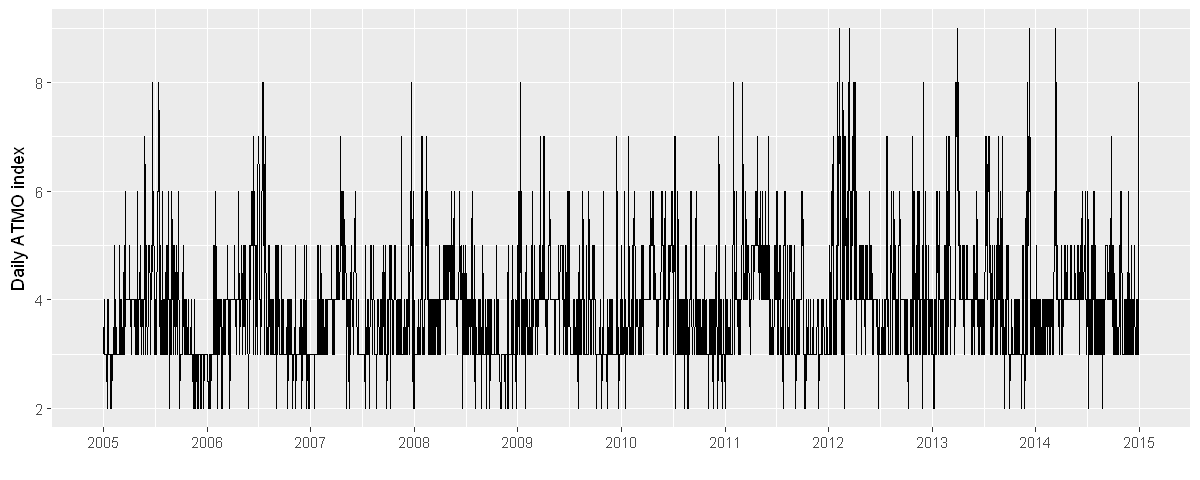

In [273]:
ggplot(data=Train_imp) + 
  geom_line(aes(x = DATE, y = INDICE_ATMO)) + 
  scale_x_date(date_breaks = "1 year", date_labels = "%Y") +  
  ylab("Daily ATMO index") +
  xlab("")

Pollution is showing a lot of fluctuations from one day to another. However, even with this volatility present, we already see some patterns emerging. There seem to be a yearly pattern.

Pollution seems to be seasonal. Let's zoom into 2005 and 2010 to better see it.

In [274]:
Train_imp2005 <- Train_imp[Train_imp$year==2005,]

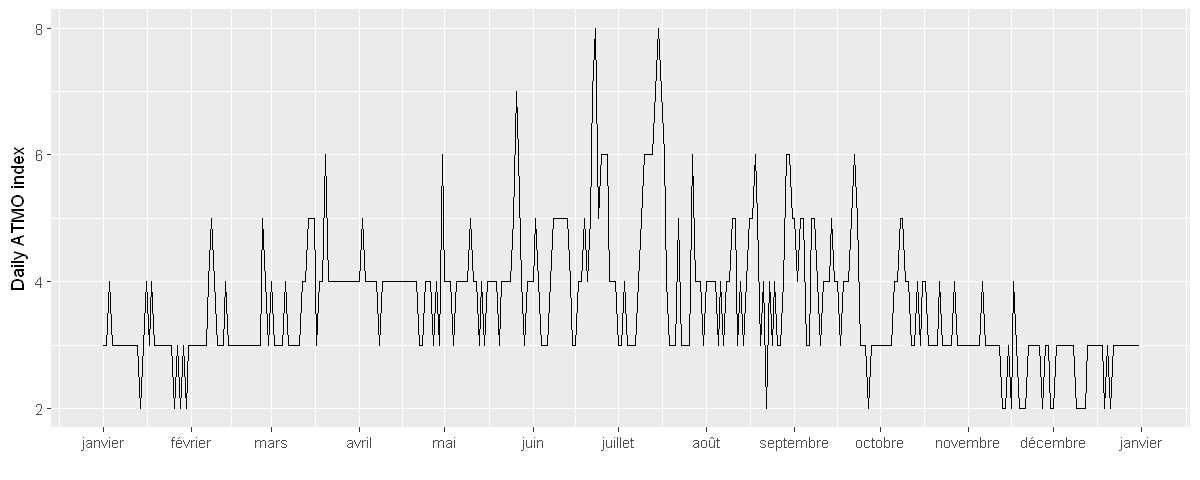

In [275]:
ggplot(data=Train_imp2005) + 
  geom_line(aes(x = DATE, y = INDICE_ATMO)) + 
  scale_x_date(date_breaks = "1 month", date_labels = "%B")  + 
  ylab("Daily ATMO index") +
  xlab("")

In 2005, the seasonality is clear, with more pollution in summer.

In [276]:
Train_imp2010 <- Train_imp[Train_imp$year==2010,]

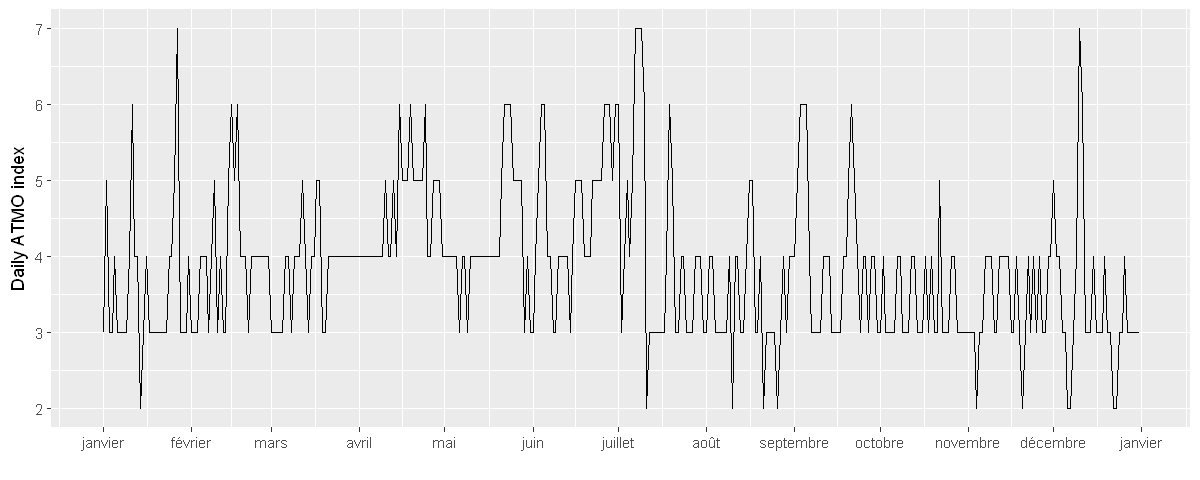

In [277]:
ggplot(data=Train_imp2010) + 
  geom_line(aes(x = DATE, y = INDICE_ATMO)) + 
  scale_x_date(date_breaks = "1 month", date_labels = "%B")  + 
  ylab("Daily ATMO index") +
  xlab("")

The seasonality is less clear in 2010, but it is still there.

### 3.2.2 Create a time series object

In [278]:
# Create a univariate time series object
Train_imp$INDICE_ATMO_ts <- ts(Train_imp$INDICE_ATMO, start=c(2005,as.numeric(format(Train_imp$DATE[1], "%j"))))
INDICE_ATMO_ts <- Train_imp$INDICE_ATMO_ts

### 3.2.3 Decomposition of the series

We are going to decompose the series. In order to do so, we have to pre-define a period for the time series. Here, we choose an annual period, so 365.25 days (i.e. average length of a year allowing for leap years).

In [279]:
# Create a time series object with a pre-defined frequency
Train_imp$INDICE_ATMO_ts365 <- ts(Train_imp$INDICE_ATMO, frequency=365.25, start=c(2005,as.numeric(format(Train_imp$DATE[1], "%j"))))
INDICE_ATMO_ts365 <- Train_imp$INDICE_ATMO_ts365

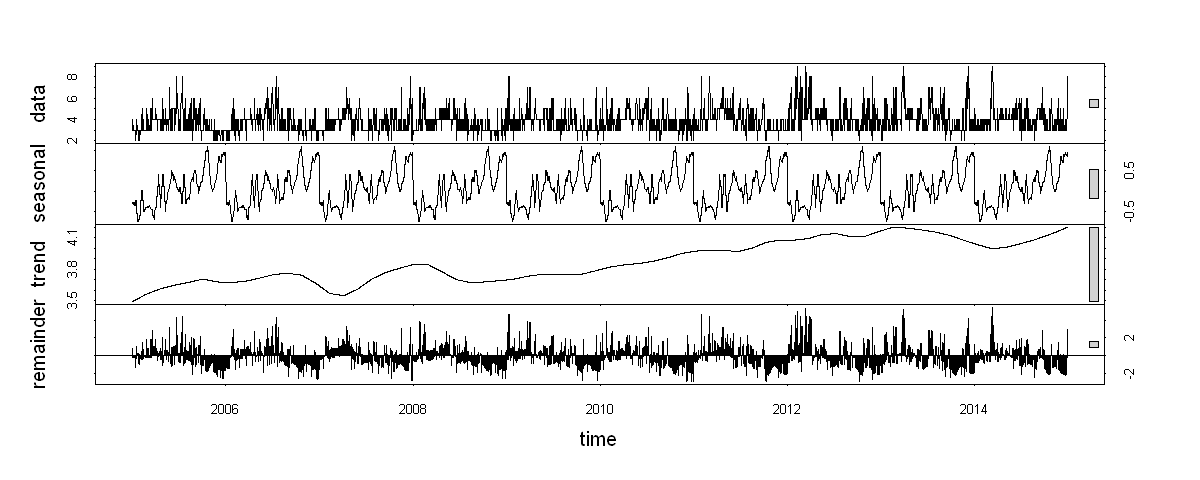

In [280]:
decompts_freq365 <- stl(INDICE_ATMO_ts365, s.window="periodic")
plot(decompts_freq365)

Here again, the seasonality is clear. We can also observe a trend with an increasing pollution.

## 3.3 Visualize relationships

### 3.3.1 Check correlations among variables

In [281]:
Train_sub <- subset(Train_imp, select=-c(DATE, INDICE_ATMO_ts, INDICE_ATMO_ts365)) 

In [282]:
correl <- hetcor(Train_sub, use = "pairwise.complete.obs")

Warning message in hetcor.data.frame(Train_sub, use = "pairwise.complete.obs"):
"the correlation matrix has been adjusted to make it positive-definite"

In [283]:
# Edited from http://www.sthda.com/french/wiki/matrice-de-correlation-guide-simple-pour-analyser-formater-et-visualiser
flattenCorrMatrix <- function(cormat) {
  ut <- upper.tri(cormat)
  data.frame(
    row = rownames(cormat)[row(cormat)[ut]],
    column = rownames(cormat)[col(cormat)[ut]],
    cor  =(cormat)[ut]
    )
}

In [284]:
flat_correl <- flattenCorrMatrix(correl$correlations)

In [285]:
flat_correl_ord <- flat_correl[order(abs(flat_correl$cor), decreasing=TRUE),]

In [286]:
flat_correl_ord[flat_correl_ord$cor>=0.3|flat_correl_ord$cor<=-0.3,]

,row,column,cor
186,wind,rafper,0.9631579
153,humidity,cloud,0.6400424
121,INDICE_ATMO,humidity,-0.4721492
388,month_8,holidays,0.4294822
436,INDICE_ATMO,polPeak,0.3997786
137,INDICE_ATMO,cloud,-0.3984128
209,pres,rain24,-0.3867580
190,pres,rafper,-0.3818229
387,month_7,holidays,0.3774289
168,wind,pres,-0.3753956


### 3.3.2 Temperature

In [287]:
# Give a proper size to plots
options(repr.plot.width=4, repr.plot.height=4)

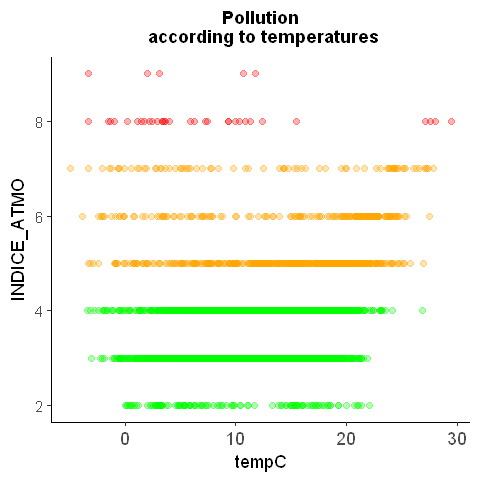

In [288]:
ggplot(data=Train_imp) + 
  geom_point(aes(y = INDICE_ATMO, x = tempC, colour=factor(INDICE_ATMO))) +
  labs(title = "Pollution\n according to temperatures") +
  scale_colour_manual(values = alpha(c("green","green","green","orange","orange","orange","red","red"), 0.3), guide=FALSE) +
  theme_new

We observe that pollution peaks appear mainly when it is cold, although some peaks also appear when it is hot. There is no pollution peak in between.

### 3.3.3 Cloudiness

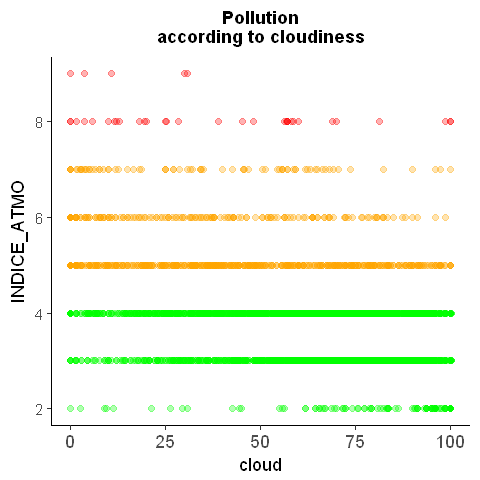

In [289]:
ggplot(data=Train_imp) + 
  geom_point(aes(y = INDICE_ATMO, x = cloud, colour=factor(INDICE_ATMO))) +
  labs(title = "Pollution\naccording to cloudiness") +
  scale_colour_manual(values = alpha(c("green","green","green","orange","orange","orange","red","red"), 0.3), guide=FALSE) +
  theme_new

The cloudiness appears to have a slight effect on pollution: the pollution tends to be higher when there are less clouds.

### 3.3.4 Wind

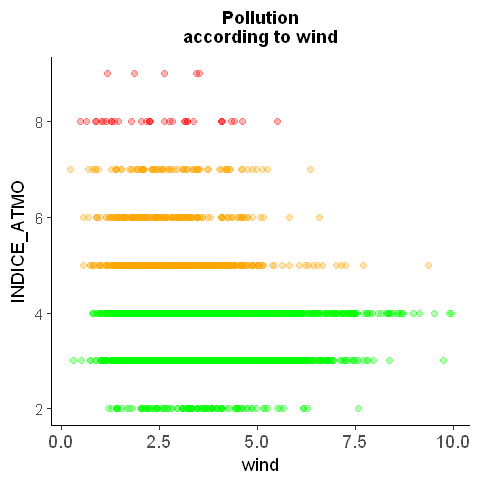

In [290]:
ggplot(data=Train_imp) + 
  geom_point(aes(y = INDICE_ATMO, x = wind, colour=factor(INDICE_ATMO))) +
  labs(title = "Pollution\naccording to wind") +
  scale_colour_manual(values = alpha(c("green","green","green","orange","orange","orange","red","red"), 0.3), guide=FALSE) +
  theme_new

There is a clear relationship between wind and pollution peak: when the wind is weak, the risk of pollution peak is larger. This is logical because the wind tends to disperse particles.

### 3.3.5 Rain

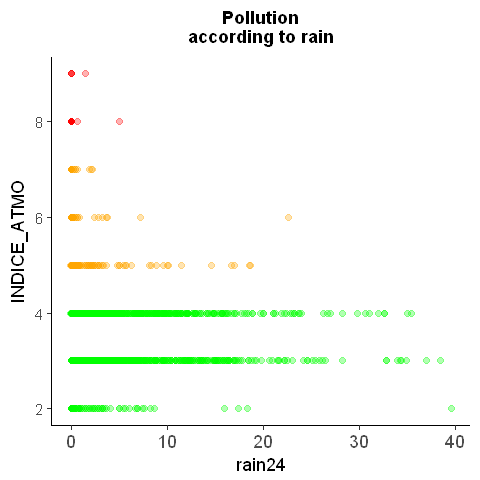

In [291]:
ggplot(data=Train_imp) + 
  geom_point(aes(y = INDICE_ATMO, x = rain24, colour=factor(INDICE_ATMO))) +
  labs(title = "Pollution\naccording to rain") +
  scale_colour_manual(values = alpha(c("green","green","green","orange","orange","orange","red","red"), 0.3), guide=FALSE) +
  theme_new

Here again, the relationship is clear: when it rains, the risk of pollution peak is smaller. Indeed, rain clears the sky from particles.

### 3.3.6 Traffic

In [292]:
table(Train_imp$goReturnHolidays, Train_imp$INDICE_ATMO>=8)

   
    FALSE TRUE
  0  3416   36
  1   199    1

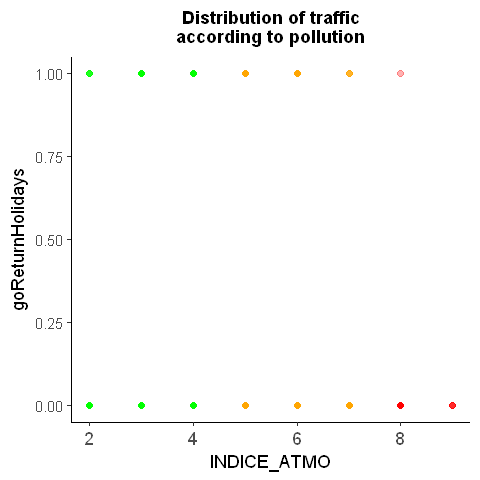

In [293]:
ggplot(data=Train_imp) + 
  geom_point(aes(x = INDICE_ATMO, y = goReturnHolidays, colour=factor(INDICE_ATMO))) +
  labs(title = "Distribution of traffic\naccording to pollution") +
  scale_colour_manual(values = alpha(c("green","green","green","orange","orange","orange","red","red"), 0.3), guide=FALSE) +
  theme_new

Days with a likely high traffic (when people go to and return from holidays) do not seem to be related to pollution peaks, or slightly related but in a counterintuitive way: more pollution outside traffic peaks. We have to keep in mind that our proxi may not be very accurate...

# 4 Regularized linear regression

Coming soon...

# 5 ARIMA

Let's try an ARIMA model (see https://en.wikipedia.org/wiki/Autoregressive_integrated_moving_average for more details).

* Basic assumptions made to implement these models: the time series is **linear** and follows a particular **known statistical distribution** (eg. the normal distribution). 
* Pros: high flexibility
* Cons: pre-assumed linear form of the associated time series

## 5.1 Preliminar checks

### 5.1.1 Stationarity

Fitting an ARIMA model requires the series to be stationary (i.e. mean, variance and autocovariance being invariant wrt time). Let's check it by performing a KPSS test.

In [294]:
kpss.test(INDICE_ATMO_ts)

Warning message in kpss.test(INDICE_ATMO_ts):
"p-value smaller than printed p-value"


	KPSS Test for Level Stationarity

data:  INDICE_ATMO_ts
KPSS Level = 1.564, Truncation lag parameter = 13, p-value = 0.01


The KPSS test reject the null hypothesis of stationarity. So our series is **not stationary** (which was obvious in the plots of the data).

In [295]:
ndiffs(INDICE_ATMO_ts,test = "kpss")

[1] 1

In [296]:
nsdiffs(INDICE_ATMO_ts365) 

[1] 0

**One** difference is required to make our time series stationary. However, we don't need any seasonal difference.

### 5.1.2 Plot ACF/PACF charts

They will be useful to find optimal parameters. <br>
**ACF** plots display correlation between a series and its lags. In addition to suggesting the order of differencing, ACF plots can help in determining the order of the MA (q) model. Partial autocorrelation plots (**PACF**), as the name suggests, display correlation between a variable and its lags that is not explained by previous lags. PACF plots are useful when determining the order of the AR(p) model. (https://www.datascience.com/blog/introduction-to-forecasting-with-arima-in-r-learn-data-science-tutorials)

First, let's try to confirm the order of differencing.

In [297]:
# Give a proper size to plots
options(repr.plot.width=10, repr.plot.height=4)

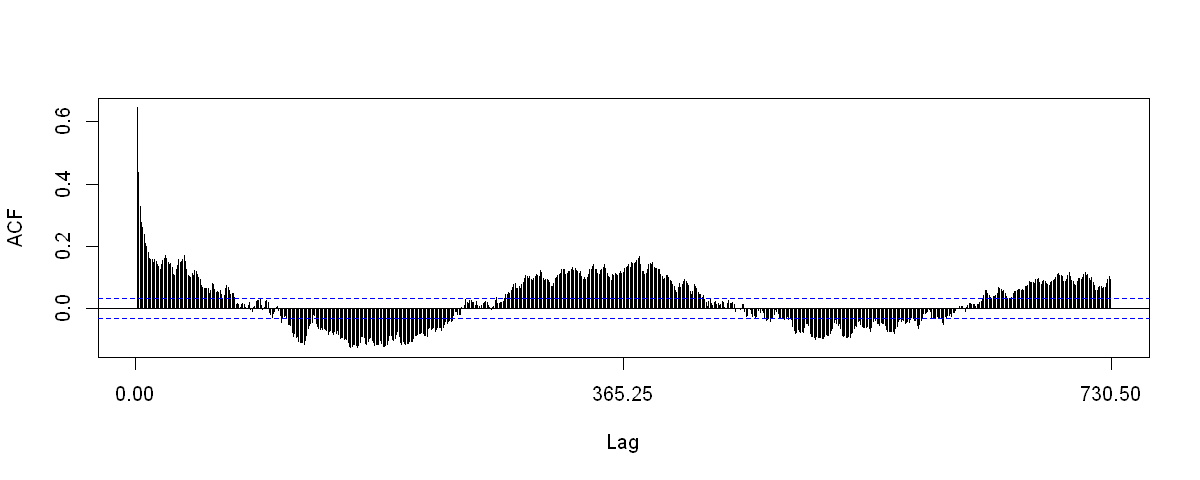

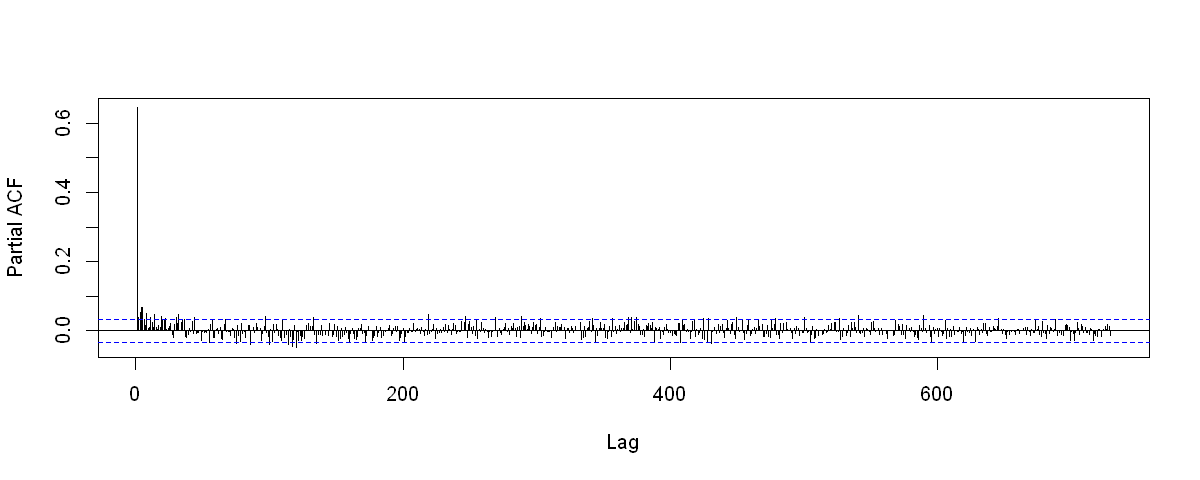

In [298]:
Acf(INDICE_ATMO_ts365, main='')
Pacf(INDICE_ATMO_ts365, main='')

As expected, the cosine-shaped autocorrelation gives a positive maximum at the lag of one year and negative maximum at the lag of half a year, reflecting the **seasonal change** during the year.<br>

Let's zoom into the PACF plot to better see the cut off.

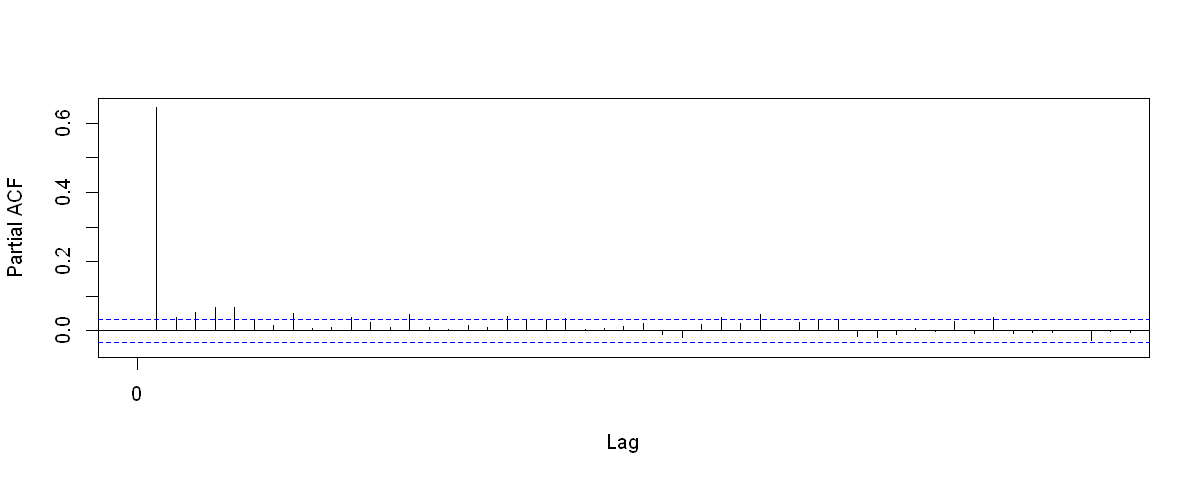

In [299]:
Pacf(INDICE_ATMO_ts365, main='', xlim=c(0,50))

### 5.1.3 Differencing the original non-stationary data

As suggested by the ndiffs() function, a difference of 1 seems to be reasonable. So let's try d=1.

In [300]:
INDICE_ATMO_365diff1 <- diff(INDICE_ATMO_ts365, differences = 1)

In [301]:
# Give a proper size to plots
options(repr.plot.width=10, repr.plot.height=4)

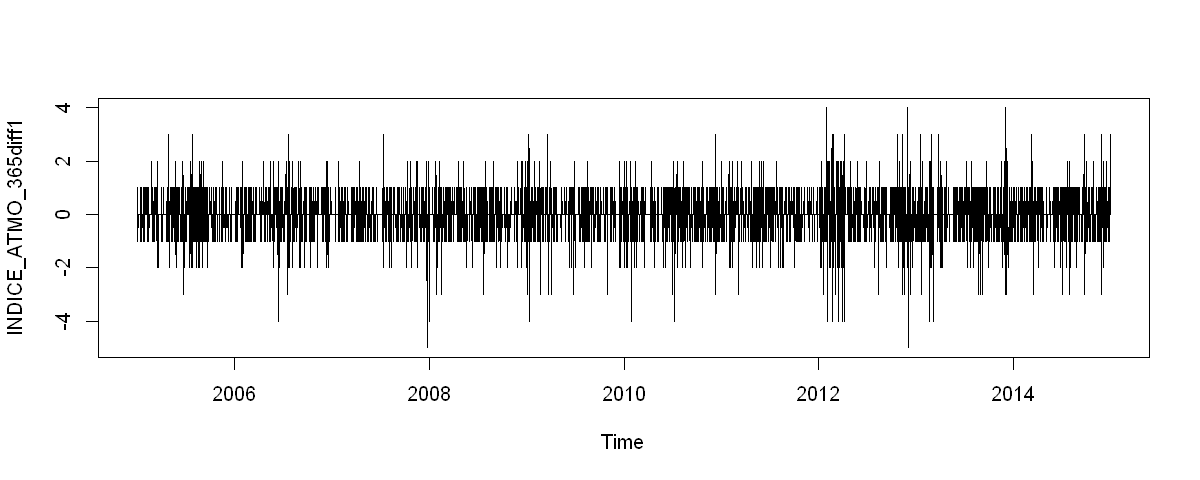

In [302]:
plot(INDICE_ATMO_365diff1)

This look stationary, so we will not consider further differences.

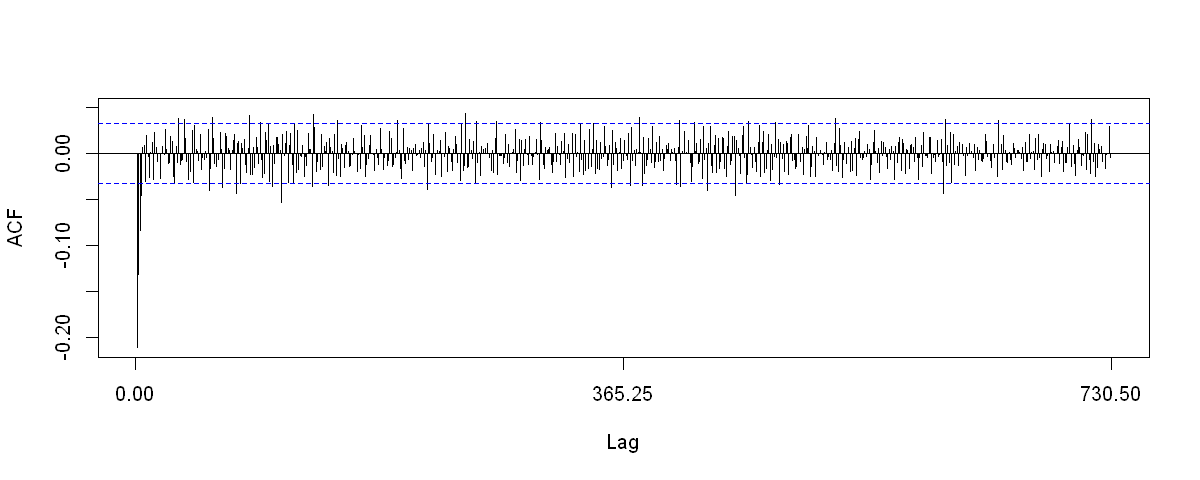

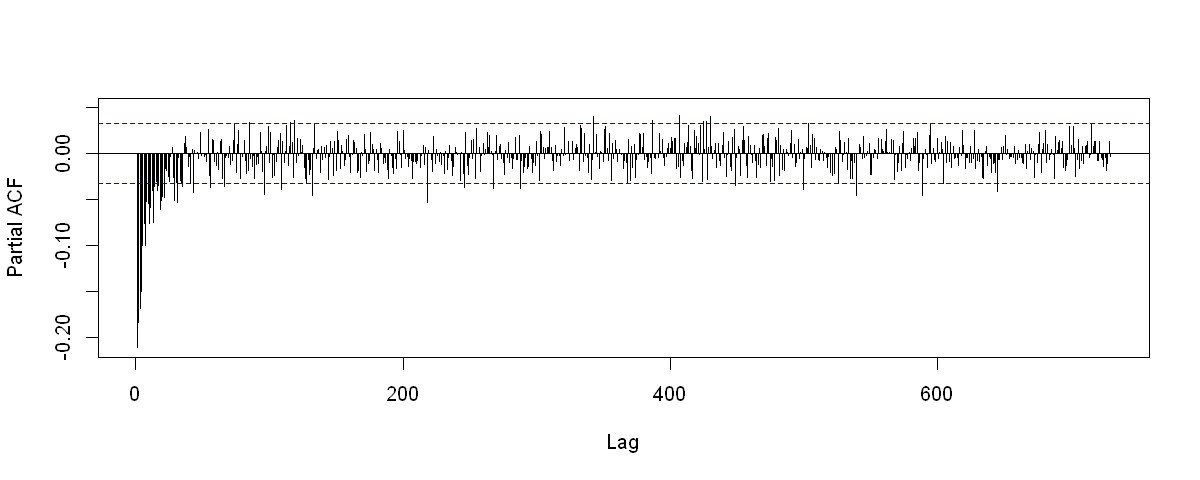

In [303]:
Acf(INDICE_ATMO_365diff1, main='')
Pacf(INDICE_ATMO_365diff1, main='')

Let's zoom in.

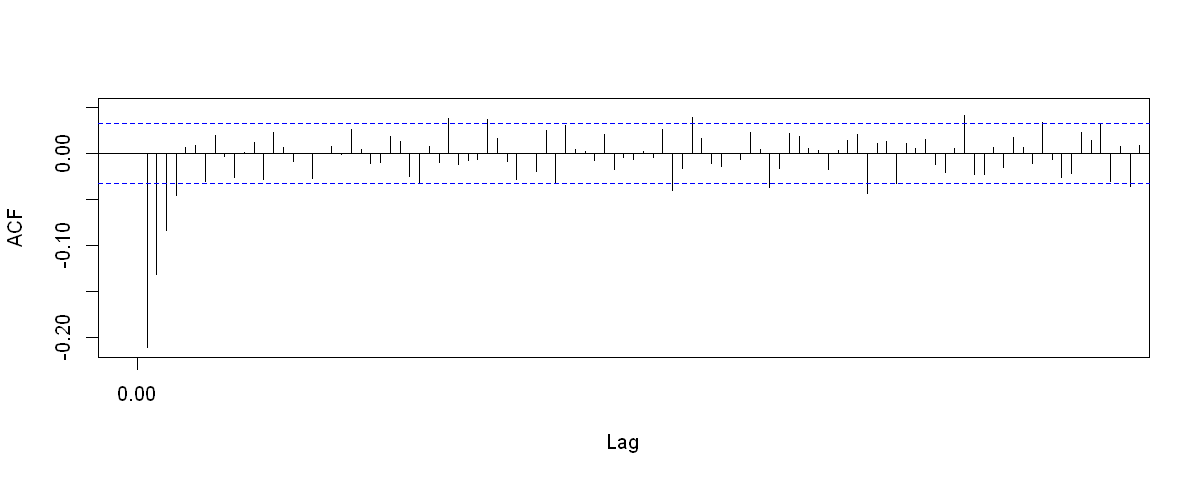

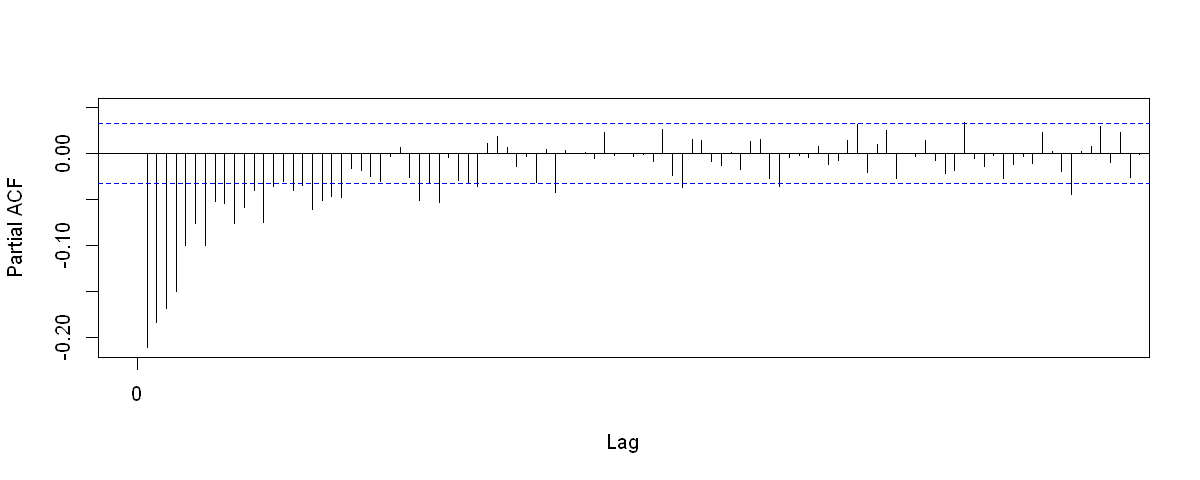

In [304]:
Acf(INDICE_ATMO_365diff1, main='', xlim=c(0,100))
Pacf(INDICE_ATMO_365diff1, main='', xlim=c(0,100))

Given the **ACF** plot (auto-correlation) and the **PACF** plot: <br>
The **p** component should be **0** given that we probably don't have an AR process.<br>
The **d** component is **1** as we need one difference to make the series stationary.<br>
The **q** component should be **4** given that the process seems to be AM(4).

## 5.2 Build models

Let's check the variances

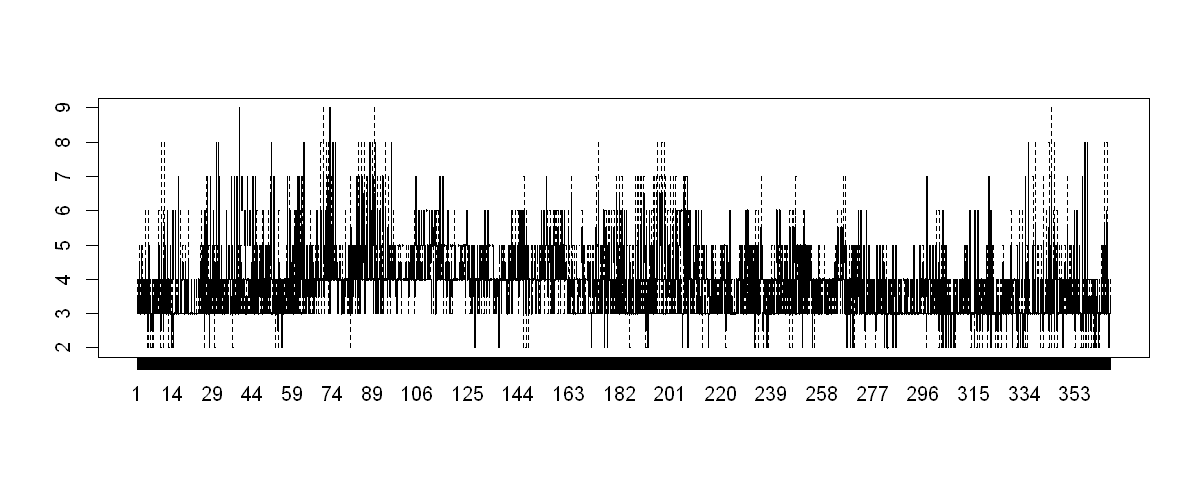

In [305]:
boxplot(INDICE_ATMO_ts365~cycle(INDICE_ATMO_ts365))

Let's zoom in.

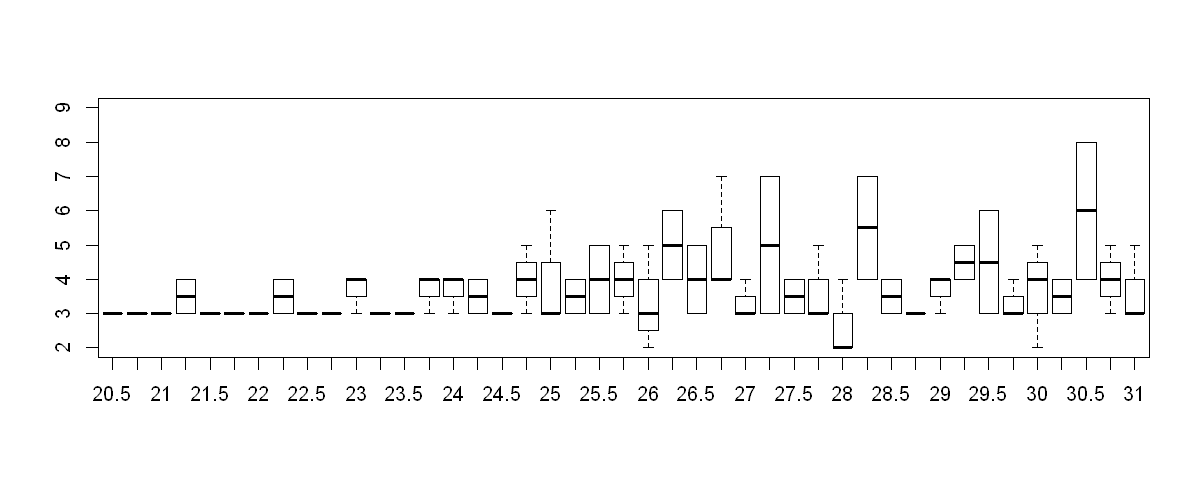

In [306]:
boxplot(INDICE_ATMO_ts365~cycle(INDICE_ATMO_ts365), xlim=c(80,120))

There is evidence of changing variance according to the day of the year, so we will do a Box-Cox transformation.

### 5.2.1 Quick and dirty

In [307]:
fit_365 <- auto.arima(INDICE_ATMO_ts365, seasonal=FALSE, lambda= BoxCox.lambda(INDICE_ATMO_ts365), biasadj=TRUE)

In [308]:
# Give a proper size to plots
options(repr.plot.width=10, repr.plot.height=4)

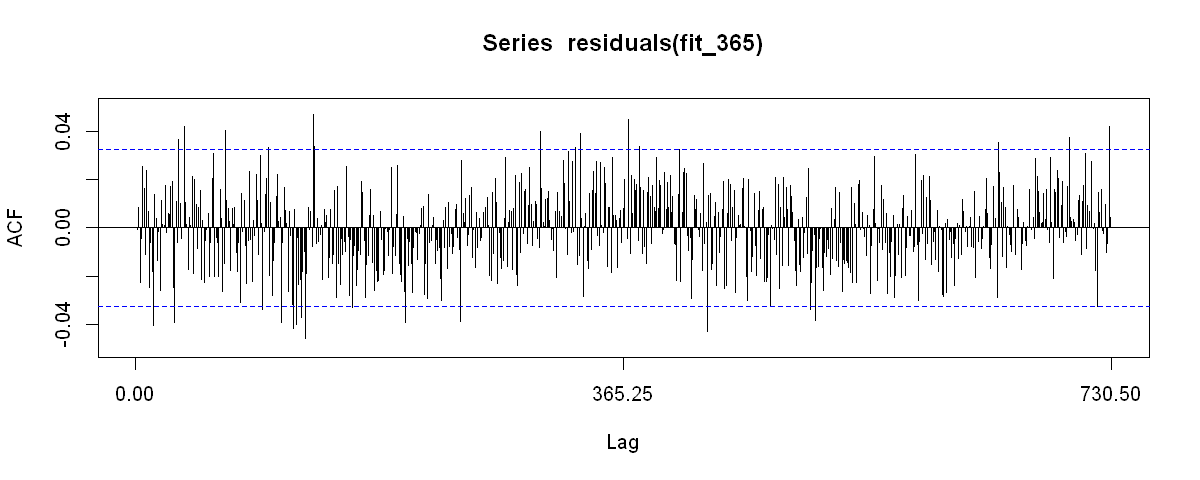

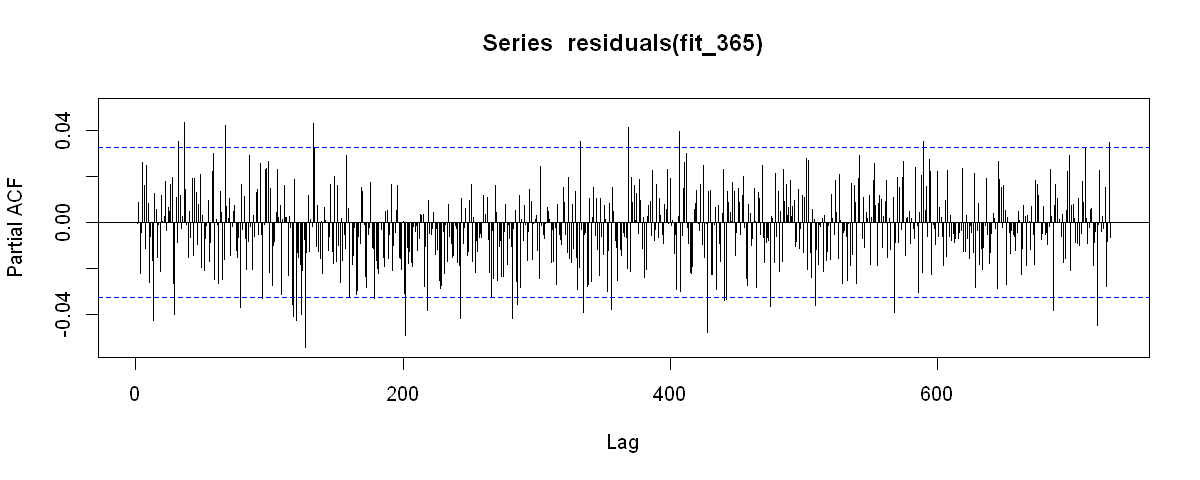

In [309]:
Acf(residuals(fit_365))
Pacf(residuals(fit_365))

There seems to be only white noise remaining.
We can confirm this by performing a **Ljung–Box test** (that tests whether any of a group of autocorrelations of the residual time series are different from zero).<br>
We use fitdf = p + q and lag = 2 * period of seasonality (following https://robjhyndman.com/hyndsight/ljung-box-test/).

In [310]:
arimaorder(fit_365)

[1] 1 1 2

This is rather far from what we expected (i.e. an ARIMA(0,1,4))...

In [311]:
Box.test(residuals(fit_365), lag=730.5, type="Ljung", fitdf=sum(arimaorder(fit_365)[c(1,3)]))$p.value

[1] 0.3101144

In [312]:
fc_365 <- forecast(fit_365, h=365)

Now, we can compare the model (blue) to the actual data (black) in the **validation set** (2015).

In [313]:
Val$INDICE_ATMO_ts365 <- ts(Val$INDICE_ATMO, frequency=365.25, start=c(2015,as.numeric(format(Val$DATE[1], "%j"))))

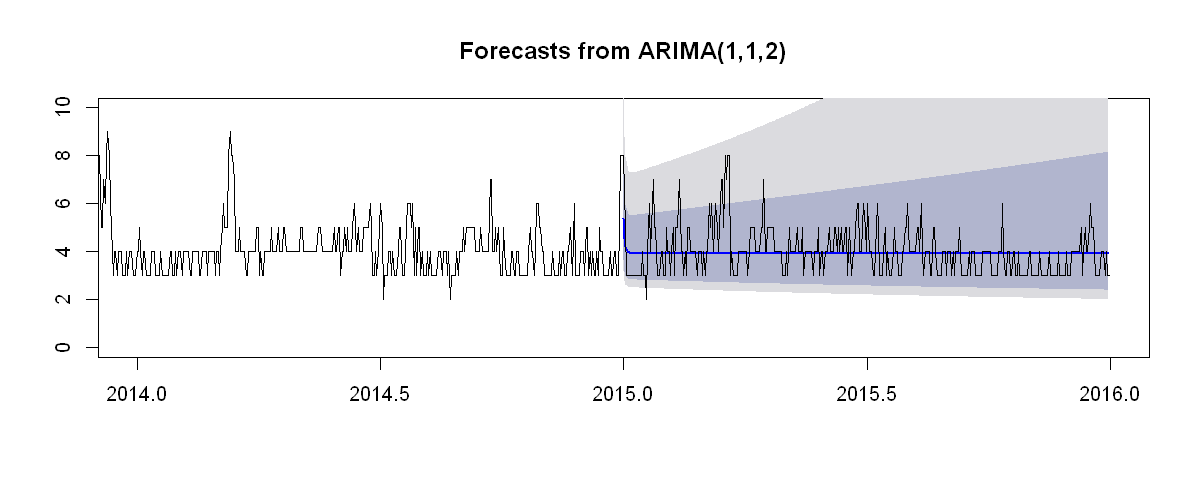

In [314]:
plot(fc_365, ylim=c(0,10), xlim=c(2014,2016))
lines(Val$INDICE_ATMO_ts365)

The predictions are very bad!

Let's check various **performance measures**:
* ME: Mean Error: measures the average deviation of forecasted values from actual ones (should be as close to zero as possible)
* RMSE: Root Mean Squared Error:  measures the square root of the average squared deviation of forecasted values.
* MAE: Mean Absolute Error:  measures the average absolute deviation of forecasted values from original ones (should be as small as possible)
* MPE: Mean Percentage Error:  percentage of average error occurred, while forecasting (should be small)
* MAPE: Mean Absolute Percentage Error:  percentage of average absolute error occurred
* MASE: Mean Absolute Scaled Error
* ACF1: Autocorrelation of errors at lag 1.
* Theil’s U-statistics: normalized measure of total forecast error (should be as close to zero as possible)

In [315]:
# Forecast accuracy measures
accuracy(f=fc_365, x=Val$INDICE_ATMO_ts365)

,ME,RMSE,MAE,MPE,MAPE,MASE,ACF1,Theil's U
Training set,-0.01660147,0.8333237,0.6144700,-4.509692,16.30685,0.6375514,0.1214625,NA
Test set,0.04122625,0.9899692,0.6989901,-4.367430,17.73434,0.7252464,0.5069524,1.009512


It may be because we **didn't take into account seasonality** (seasonal=FALSE). The problem is that R does not fit an ARIMA model with seasonality greater than 350 and we have a seasonality of 365.25...

Here, we can assume that the annual seasonal shape is unchanged from year to year, so **Fourier** terms could be used to model the annual seasonality. Let's try.

### 5.2.2 Add seasonality (with Fourier terms)

#### Fourier with k=5

In [316]:
four5_365 <- fourier(INDICE_ATMO_ts365, K=5)
four5_365f <- fourier(INDICE_ATMO_ts365, K=5, h=365)

In [317]:
fit_fourier5_365 <- auto.arima(INDICE_ATMO_ts365, seasonal=FALSE, lambda= BoxCox.lambda(INDICE_ATMO_ts365), biasadj=TRUE, xreg=four5_365)

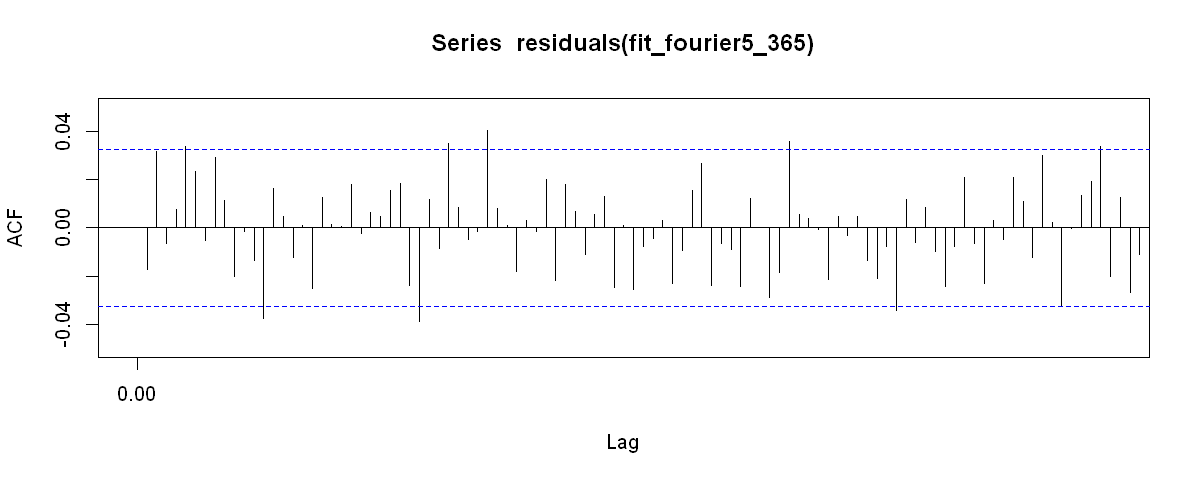

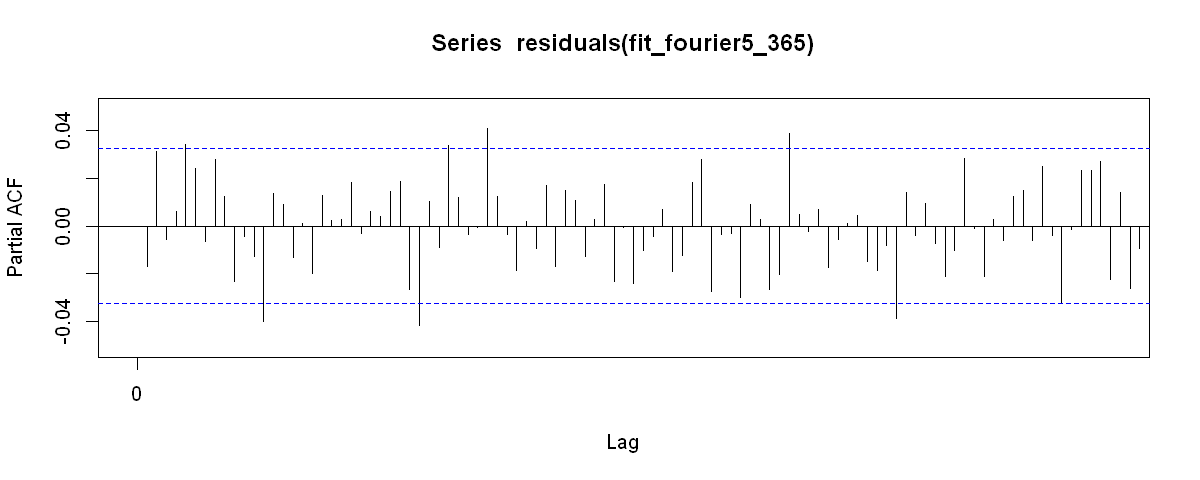

In [318]:
Acf(residuals(fit_fourier5_365), xlim=c(0,100)) 
Pacf(residuals(fit_fourier5_365), xlim=c(0,100))

In the case of deseasonal data, there is still a clear pattern present in model residuals plots. This is confirmed by the following **Ljung–Box test**.

In [319]:
arimaorder(fit_fourier5_365)

[1] 1 1 1

In [320]:
Box.test(residuals(fit_fourier5_365), lag=730.5, fitdf=sum(arimaorder(fit_fourier5_365)[c(1,3)]), type="Ljung")$p.value

[1] 0.7239844

In [321]:
fc_four5_365 <- forecast(fit_fourier5_365, xreg=four5_365f, h=365)

Let's plot the model and the forecast.

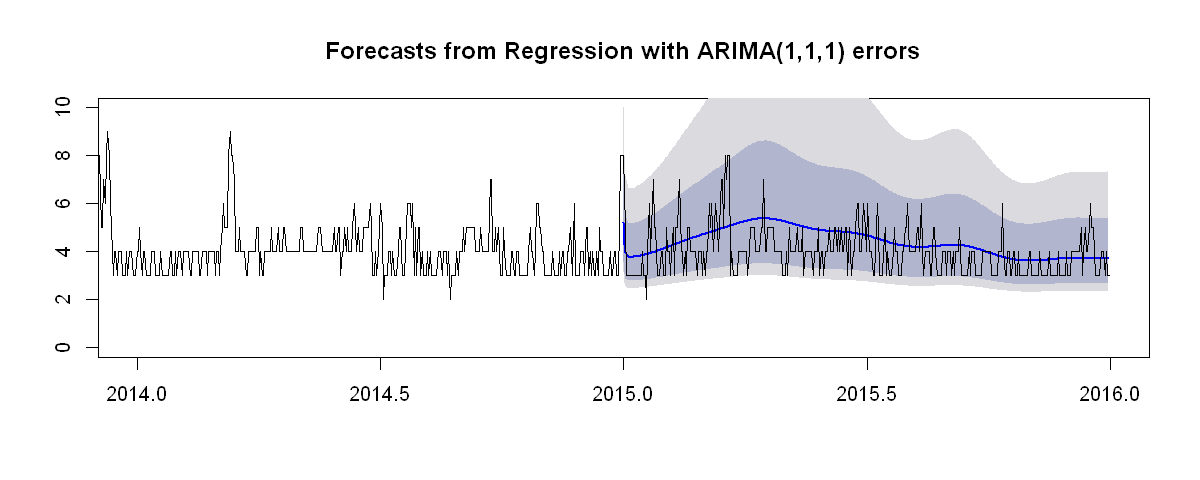

In [322]:
plot(fc_four5_365, ylim=c(0,10), xlim=c(2014,2016))
lines(Val$INDICE_ATMO_ts365)

In [323]:
# Forecast accuracy measures
accuracy(f=fc_four5_365, x=Val$INDICE_ATMO_ts365)

,ME,RMSE,MAE,MPE,MAPE,MASE,ACF1,Theil's U
Training set,-0.000792868,0.830737,0.6144967,-4.159811,16.16644,0.6375791,0.1277809,NA
Test set,-0.416069100,1.046072,0.8546219,-15.343396,23.02389,0.8867242,0.4697611,1.146827


#### Fourier with k=30

In [324]:
four30_365 <- fourier(INDICE_ATMO_ts365, K=30)
four30_365f <- fourier(INDICE_ATMO_ts365, K=30, h=365)

In [325]:
fit_fourier30_365 <- auto.arima(INDICE_ATMO_ts365, seasonal=FALSE, lambda= BoxCox.lambda(INDICE_ATMO_ts365), biasadj=TRUE, xreg=four30_365) 

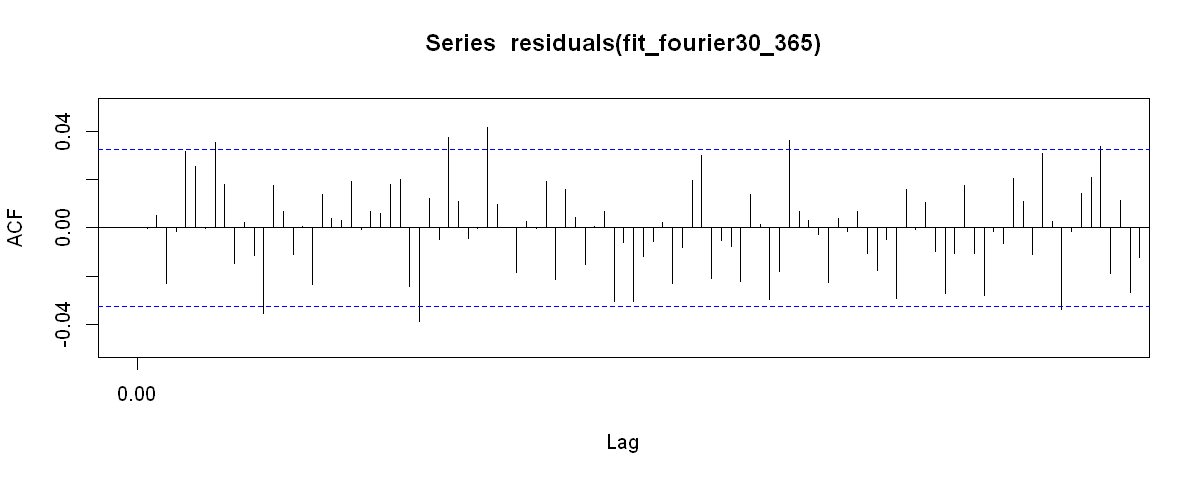

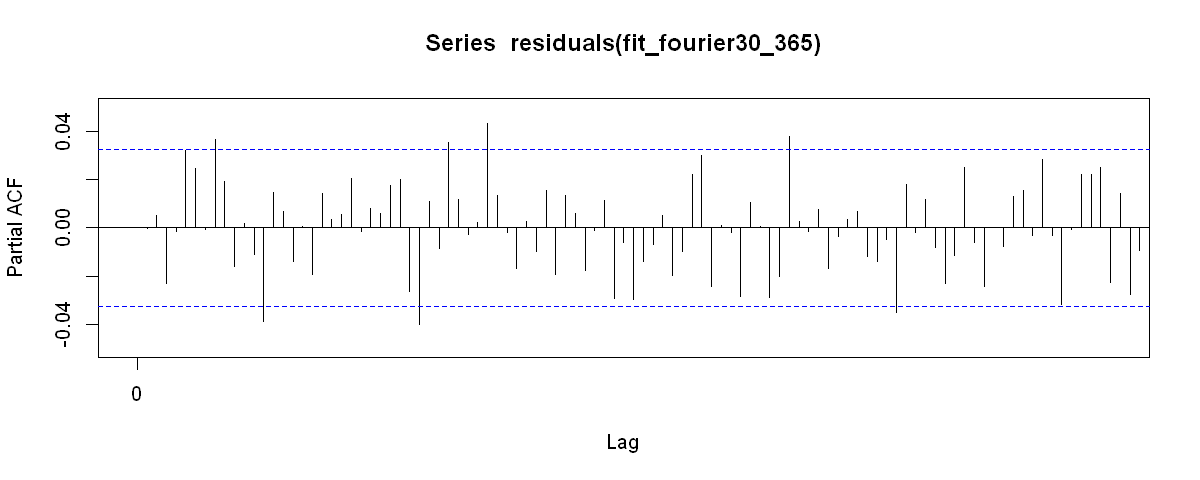

In [326]:
Acf(residuals(fit_fourier30_365), xlim=c(0,100))
Pacf(residuals(fit_fourier30_365), xlim=c(0,100))

There is no clear pattern remaining in model residuals plots which is confirmed by the following **Ljung–Box test**.

In [327]:
arimaorder(fit_fourier30_365)

[1] 1 1 2

In [328]:
Box.test(residuals(fit_fourier30_365), lag=730.5, fitdf=sum(arimaorder(fit_fourier30_365)[c(1,3)]), type="Ljung")$p.value

[1] 0.493031

In [329]:
fc_four30_365 <- forecast(fit_fourier30_365, xreg=four30_365f, h=365)

Let's plot the model and the forecast.

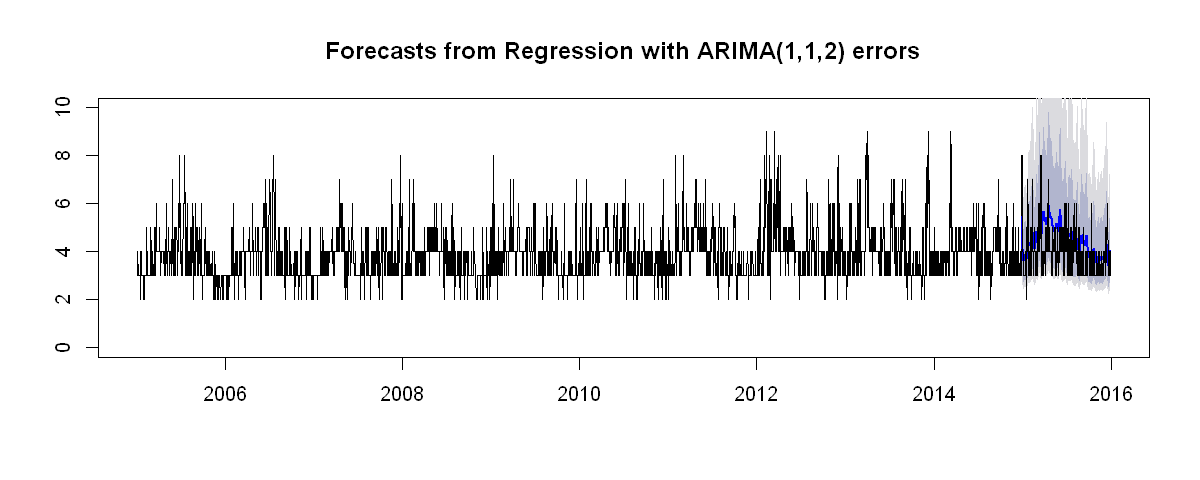

In [390]:
plot(fc_four30_365, ylim=c(0,10))
lines(Val$INDICE_ATMO_ts365)

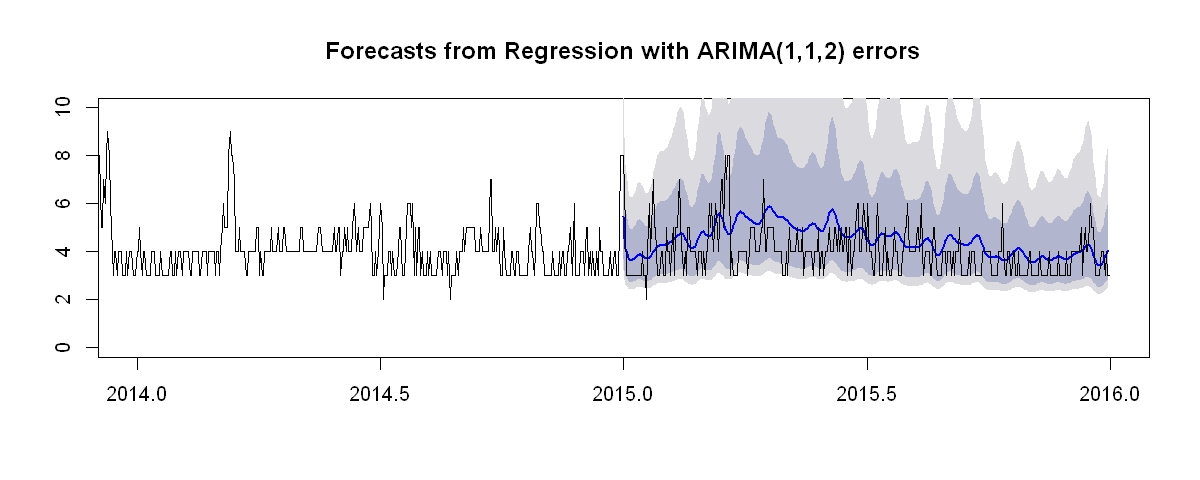

In [331]:
plot(fc_four30_365, ylim=c(0,10), xlim=c(2014,2016))
lines(Val$INDICE_ATMO_ts365)

The model still performs rather poorly and it does not predict the peaks!

In [332]:
# Forecast accuracy measures
accuracy(f=fc_four30_365, x=Val$INDICE_ATMO_ts365)

,ME,RMSE,MAE,MPE,MAPE,MASE,ACF1,Theil's U
Training set,-0.01009482,0.8239045,0.6105912,-4.320098,16.09803,0.6335269,0.1369593,NA
Test set,-0.51105393,1.1080220,0.9141352,-17.784420,24.74555,0.9484730,0.4933006,1.232449


#### Multi-Seasonality

It is possible that we have a multi-seasonality here. Let's check it.

In [333]:
findfrequency(Train_imp$INDICE_ATMO_ts)

[1] 24

In [334]:
y_24_365 <- msts(INDICE_ATMO_ts365, ts.frequency=365.25, seasonal.periods=c(24,365.25), start=c(2005,as.numeric(format(Train_imp$DATE[1], "%j"))))

In [335]:
four_24_365 <- fourier(y_24_365, K=c(12,30))
four_24_365f <- fourier(y_24_365, K=c(12,30), h=365)

In [336]:
fit_multi <- auto.arima(y_24_365, seasonal=F, lambda= BoxCox.lambda(y_24_365), biasadj=TRUE, xreg=four_24_365)

In [337]:
arimaorder(fit_multi)

[1] 1 1 2

In [338]:
Box.test(residuals(fit_multi), lag=730.5, fitdf=sum(arimaorder(fit_multi)[c(1,3)]), type="Ljung")$p.value

[1] 0.3646266

In [339]:
fc_multi <- forecast(fit_multi, xreg= four_24_365f, h=365)

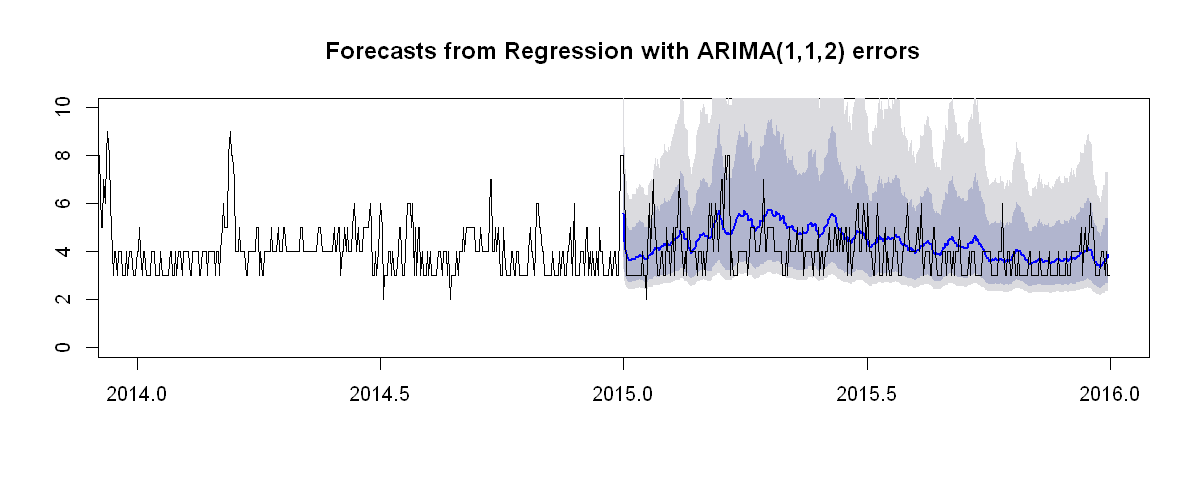

In [340]:
plot(fc_multi, ylim=c(0,10), xlim=c(2014,2016))
lines(Val$INDICE_ATMO_ts365)

The advantage of taking into account multiple seasonalities is not clear here. Let's check the performance.

In [341]:
# Forecast accuracy measures
accuracy(f=fc_multi, x=Val$INDICE_ATMO_ts365)

,ME,RMSE,MAE,MPE,MAPE,MASE,ACF1,Theil's U
Training set,-0.002135699,0.8213726,0.6071796,-4.086235,15.97005,0.6299872,0.137445,NA
Test set,-0.426819874,1.0684936,0.8732383,-15.531218,23.40821,0.9060399,0.483016,1.171424


Well, it is a bit better. Let's keep both seasonalities.

## 5.3 Add regressors

As we have seen, our model does not predict the peaks. Actually, peaks are probably due to external factors, such as the weather or the traffic. Let's take these factors into account.

In [343]:
# Prepare dataframe with external regressors
Ext_reg <- subset(Train_imp, select=c("month_2", "month_3", "month_4", "month_5", "month_6", "month_7", "month_8", "month_9", "month_10", "month_11", "month_12", "wind", "tempC", "humidity", "cloud", "pres", "rafper", "rain24", "weekday_dimanche", "weekday_jeudi", "weekday_mardi", "weekday_mercredi", "weekday_samedi", "weekday_vendredi", "holidays", "goReturnHolidays")) 
Ext_regf <- subset(Val, select=c("month_2", "month_3", "month_4", "month_5", "month_6", "month_7", "month_8", "month_9", "month_10", "month_11", "month_12", "wind", "tempC", "humidity", "cloud", "pres", "rafper", "rain24", "weekday_dimanche", "weekday_jeudi", "weekday_mardi", "weekday_mercredi", "weekday_samedi", "weekday_vendredi", "holidays", "goReturnHolidays"))

**Note**: don't forget to remove one of each dummy variable to avoid collinearity. Here we have removed "weekday_lundi" and "month_1".

In [344]:
# Prepare matrix with external regressors
Ext_reg_multi<- cbind(Ext_reg, four_24_365)
Ext_reg_mat_multi <- data.matrix(Ext_reg_multi)

Ext_regf_multi <- cbind(Ext_regf, four_24_365f)
Ext_regf_mat_multi <- data.matrix(Ext_regf_multi)

In [345]:
# Prepare matrix with external regressors
Ext_reg_365<- cbind(Ext_reg, four30_365)
Ext_reg_mat_365 <- data.matrix(Ext_reg_365)

Ext_regf_365 <- cbind(Ext_regf, four30_365f)
Ext_regf_mat_365 <- data.matrix(Ext_regf_365)

In [346]:
# Fit model and forecast
fit_multi_reg <- auto.arima(y_24_365, seasonal=FALSE, lambda= BoxCox.lambda(y_24_365), biasadj=TRUE, xreg=Ext_reg_mat_multi)

In [347]:
# Fit model and forecast
fit_365_reg <- auto.arima(INDICE_ATMO_ts365, seasonal=FALSE, lambda= BoxCox.lambda(INDICE_ATMO_ts365), biasadj=TRUE, xreg=Ext_reg_mat_365)

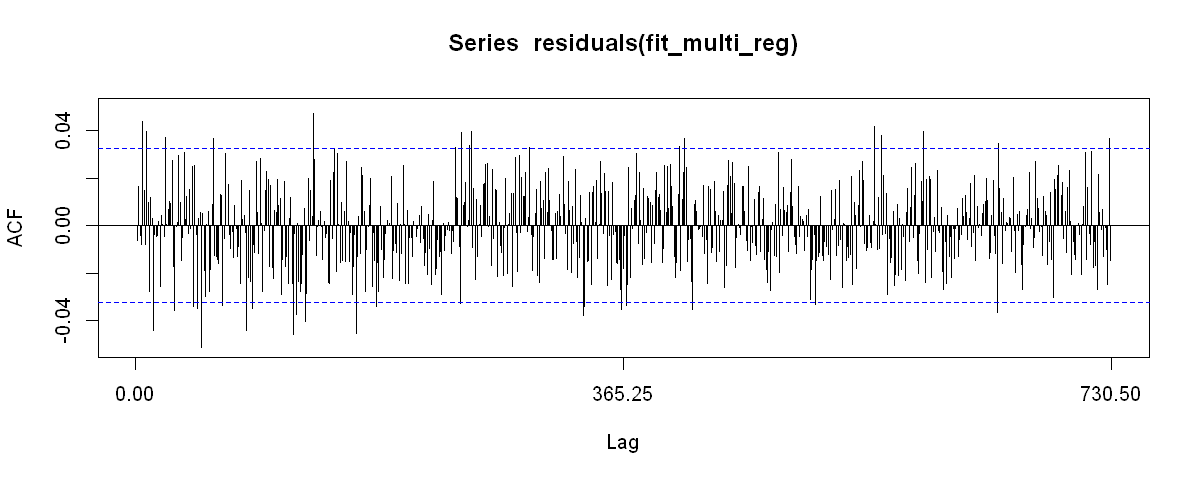

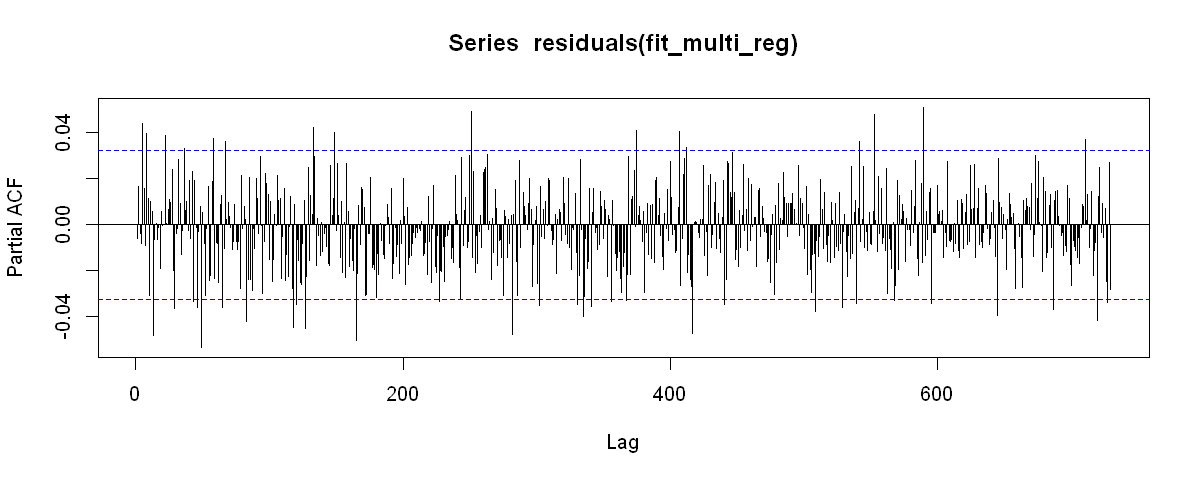

In [348]:
Acf(residuals(fit_multi_reg)) 
Pacf(residuals(fit_multi_reg))

There is no more a clear pattern present in model residuals plots which is confirm by the following **Ljung–Box test**.

In [349]:
arimaorder(fit_multi_reg)
arimaorder(fit_365_reg)

[1] 1 1 1

[1] 1 1 1

In [350]:
Box.test(residuals(fit_multi_reg), lag=730.5, fitdf=sum(arimaorder(fit_multi_reg)[c(1,3)]), type="Ljung")$p.value

[1] 0.01155458

In [351]:
Box.test(residuals(fit_365_reg), lag=730.5, fitdf=sum(arimaorder(fit_365_reg)[c(1,3)]), type="Ljung")$p.value

[1] 0.02162533

In [352]:
fc_multi_reg <- forecast(fit_multi_reg, xreg=Ext_regf_mat_multi, h=365)

In [353]:
fc_365_reg <- forecast(fit_365_reg, xreg=Ext_regf_mat_365, h=365)

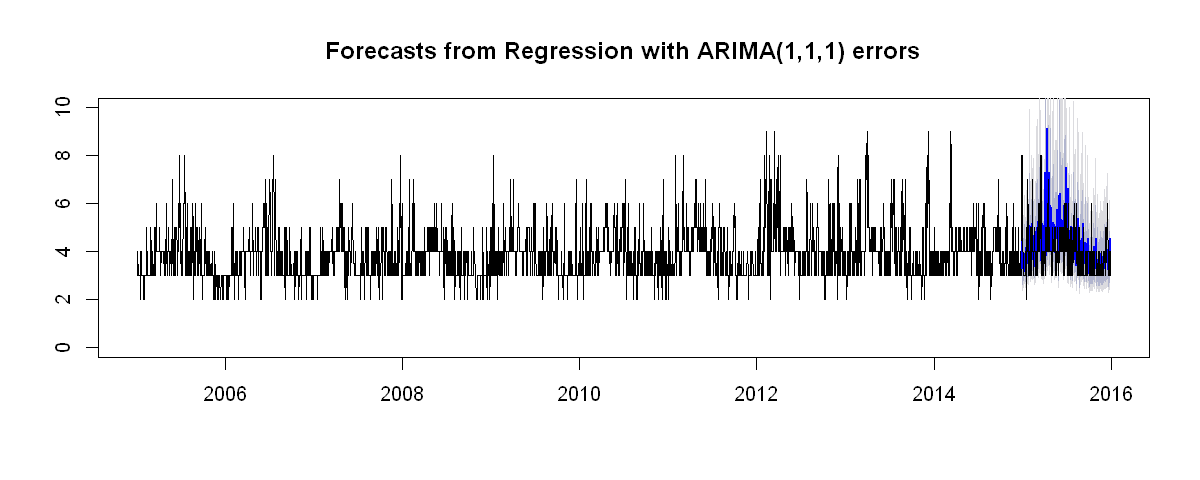

In [354]:
plot(fc_multi_reg, ylim=c(0,10))
lines(Val$INDICE_ATMO_ts365)

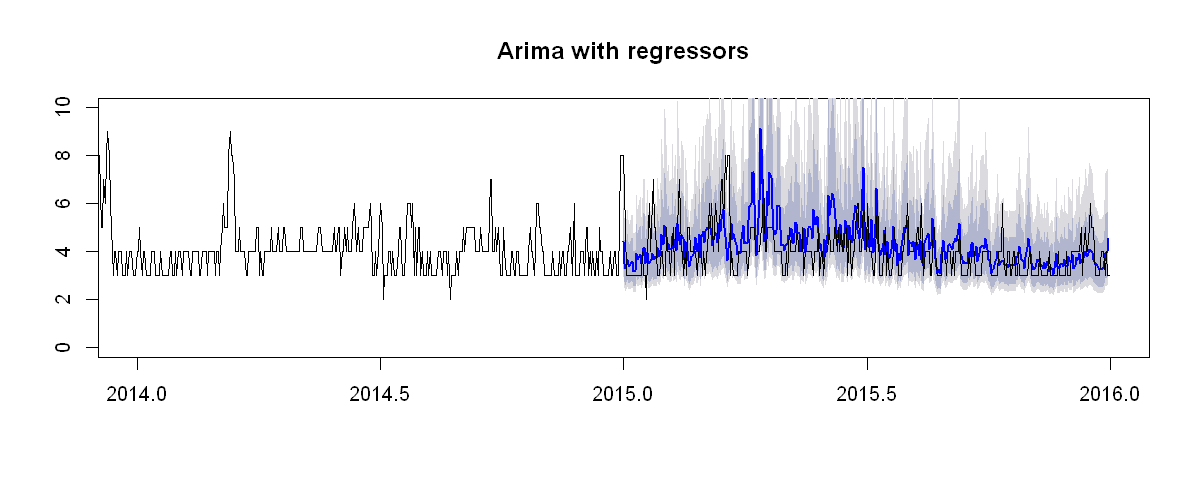

In [355]:
plot(fc_multi_reg, , main="Arima with regressors", ylim=c(0,10), xlim=c(2014,2016))
lines(Val$INDICE_ATMO_ts365)

This is even better than the Arima model without regressors that we can remind here:

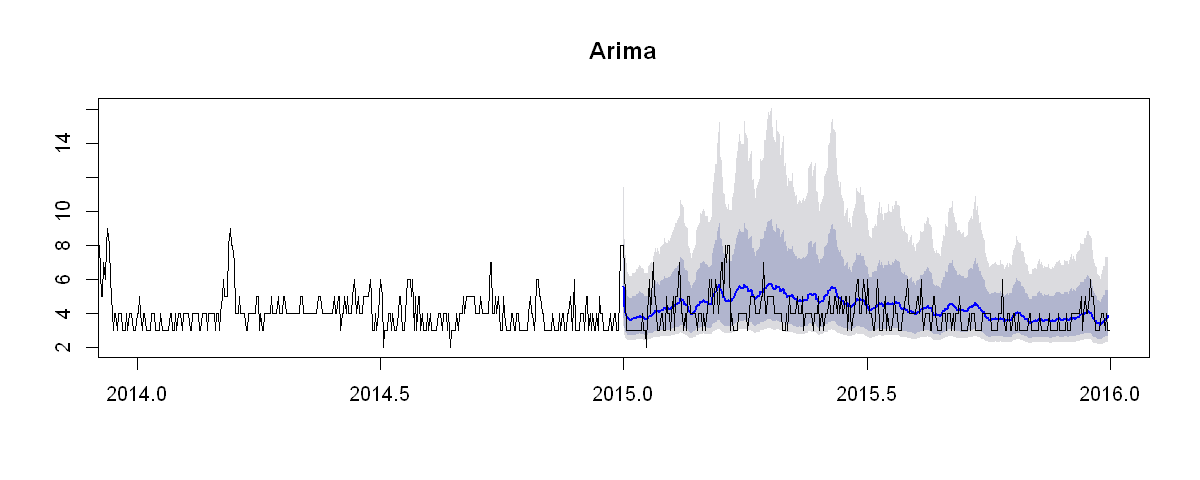

In [356]:
plot(fc_multi, main="Arima", xlim=c(2014,2016))
lines(Val$INDICE_ATMO_ts365)

However, the model still doesn't well predict the peaks...

In [357]:
# Forecast accuracy measures
accuracy(f=fc_multi_reg, x=Val$INDICE_ATMO_ts365)

,ME,RMSE,MAE,MPE,MAPE,MASE,ACF1,Theil's U
Training set,-0.007873774,0.7704269,0.5564256,-3.460281,14.45653,0.5773267,0.1299060,NA
Test set,-0.329768882,1.1743804,0.9011457,-12.684336,23.10911,0.9349955,0.3604124,1.226622


In [358]:
# Forecast accuracy measures
accuracy(f=fc_365_reg, x=Val$INDICE_ATMO_ts365)

,ME,RMSE,MAE,MPE,MAPE,MASE,ACF1,Theil's U
Training set,-0.00782853,0.7724091,0.5568272,-3.477869,14.47594,0.5777434,0.1289898,NA
Test set,-0.33497390,1.1786976,0.9020556,-12.829657,23.16011,0.9359396,0.3609532,1.231852


The best model seems to be **fit_fourier30_365d_reg**.

#  6 Artificial Neural Networks (feed forward network)

* Pros: non-linear modeling, no presumption about the statistical distribution followed by the observations.
* Cons: ?

## 6.1 Build models

### 6.1.1 Quick and dirty

In [359]:
fit_nn_365 <- nnetar(INDICE_ATMO_ts365, P = 1, repeats = 20, lambda= BoxCox.lambda(INDICE_ATMO_ts365))

In [360]:
fc_nn_365 <- forecast(fit_nn_365, h=365)

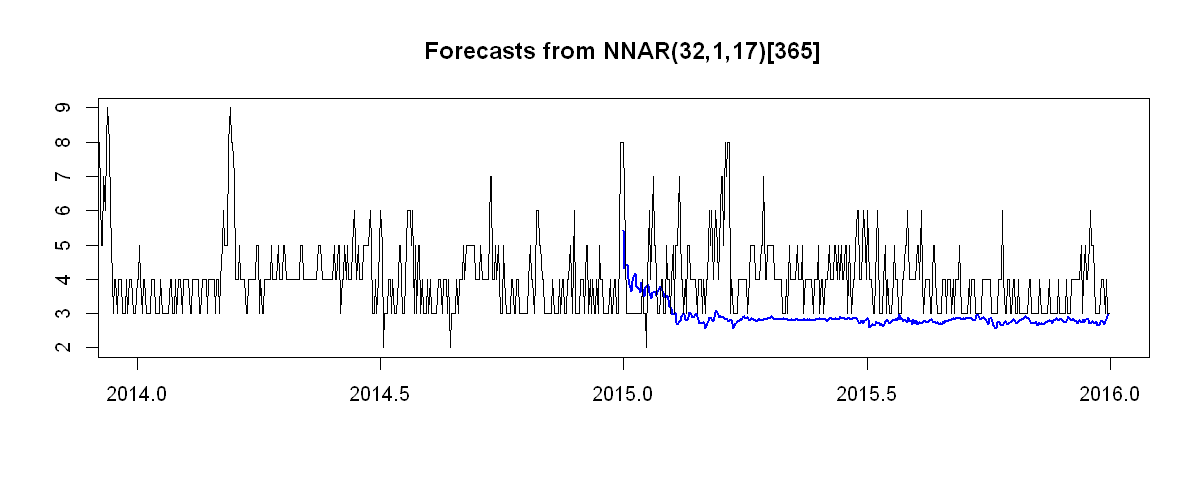

In [361]:
plot(fc_nn_365, xlim=c(2014,2016))
lines(Val$INDICE_ATMO_ts365)

In [362]:
# Forecast accuracy measures
accuracy(f=fc_nn_365, x=Val$INDICE_ATMO_ts365)

,ME,RMSE,MAE,MPE,MAPE,MASE,ACF1,Theil's U
Training set,0.1290263,0.5550401,0.3751316,0.828834,9.032847,0.3892227,0.1911063,NA
Test set,1.0725877,1.4977741,1.1675919,22.864848,26.198290,1.2114503,0.5560037,1.489206


### 6.1.2 Add seasonality (with Fourier terms)

#### Fourier with k=30

In [363]:
# Fit model and forecast
fit_nn_fourier30_365 <- nnetar(INDICE_ATMO_ts365, P = 1, repeats = 20, lambda= BoxCox.lambda(INDICE_ATMO_ts365), xreg=four30_365, MaxNWts=4500)

In [364]:
fc_nn_fourier30_365 <- forecast(fit_nn_fourier30_365, xreg=four30_365f, h=365)

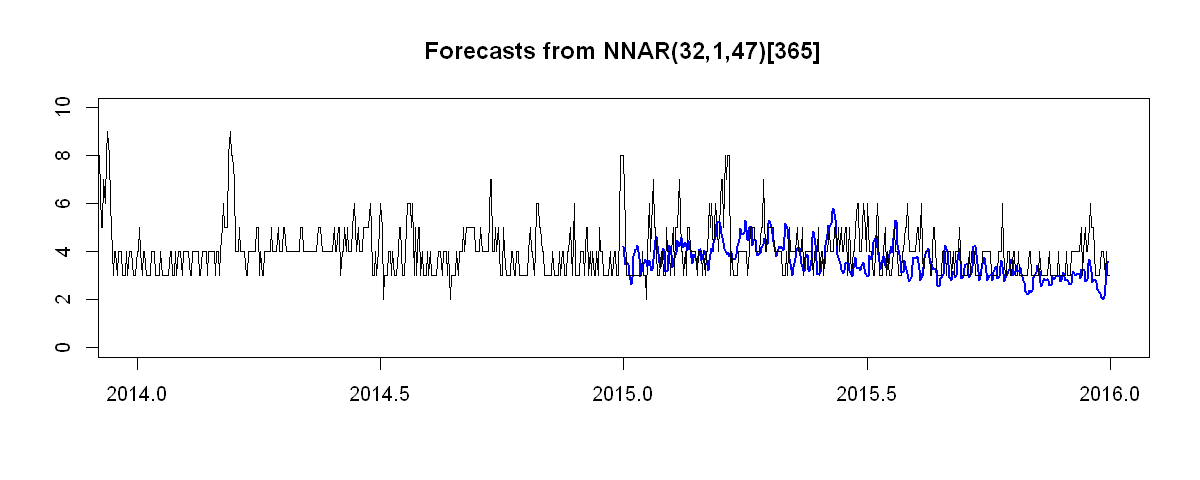

In [365]:
plot(fc_nn_fourier30_365, xlim=c(2014,2016), ylim=c(0,10))
lines(Val$INDICE_ATMO_ts365)

In [366]:
# Forecast accuracy measures
accuracy(f=fc_nn_fourier30_365, x=Val$INDICE_ATMO_ts365)

,ME,RMSE,MAE,MPE,MAPE,MASE,ACF1,Theil's U
Training set,0.004881205,0.03893411,0.02329206,0.053869,0.5511635,0.02416698,-0.03278765,NA
Test set,0.358115820,1.10198201,0.80270622,5.295731,18.9954625,0.83285838,0.51511637,1.110914


#### Multi-seasonality

In [367]:
# Fit model
fit_nn_multi <- nnetar(y_24_365, P = 1, repeats = 20, lambda= BoxCox.lambda(INDICE_ATMO_ts365d), xreg=four_24_365, MaxNWts=7000)

In [368]:
# Forecast
fc_nn_multi <- forecast(fit_nn_multi, xreg=four_24_365f, h=365)

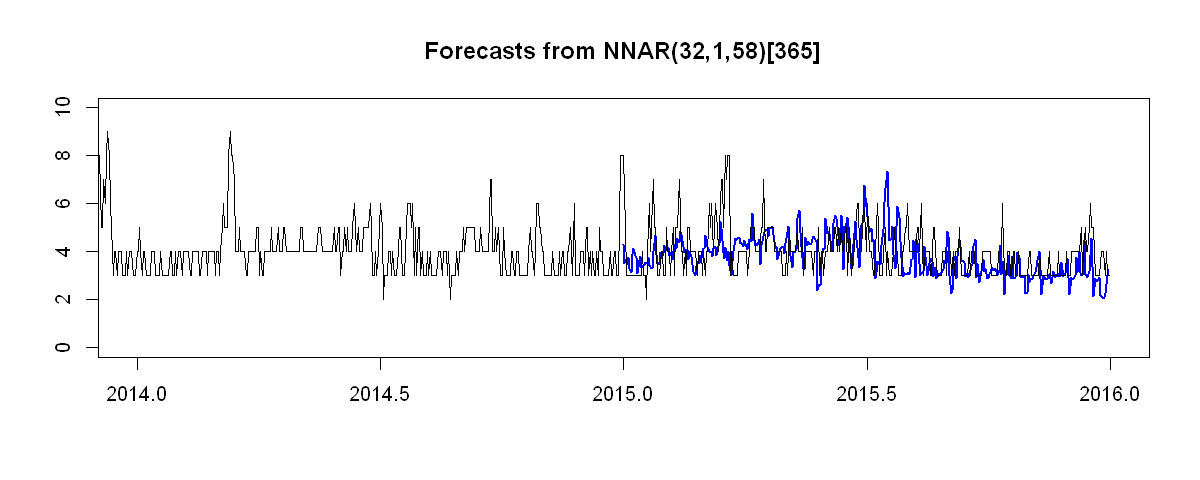

In [369]:
plot(fc_nn_multi, xlim=c(2014,2016), ylim=c(0,10))
lines(Val$INDICE_ATMO_ts365)

In [370]:
# Forecast accuracy measures
accuracy(f=fc_nn_multi, x=Val$INDICE_ATMO_ts365)

,ME,RMSE,MAE,MPE,MAPE,MASE,ACF1,Theil's U
Training set,0.000908816,0.008889296,0.006155833,0.01584481,0.148379,0.006387066,0.1385959,NA
Test set,0.156311432,1.132072976,0.827854732,0.08856936,20.192460,0.858951548,0.4979558,1.147388


### 6.1.3 Add regressors

In [371]:
fit_nn_365_reg <- nnetar(INDICE_ATMO_ts365, P = 1, repeats = 20, lambda= BoxCox.lambda(INDICE_ATMO_ts365), xreg=Ext_reg_mat_365, MaxNWts=7500)

In [372]:
fc_nn_365_reg <- forecast(fit_nn_365_reg, h=365, xreg=Ext_regf_mat_365)

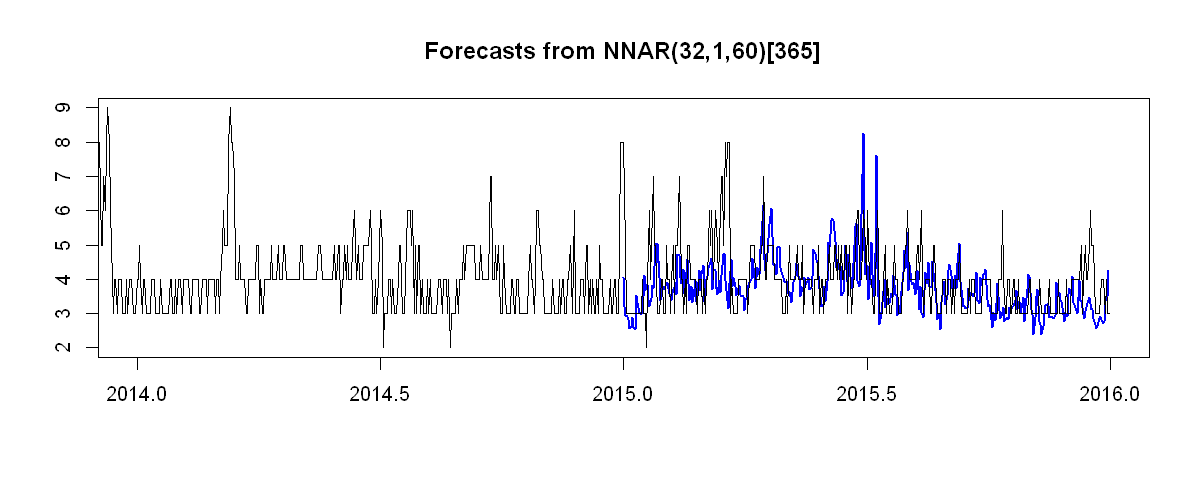

In [373]:
plot(fc_nn_365_reg, xlim=c(2014,2016))
lines(Val$INDICE_ATMO_ts365)

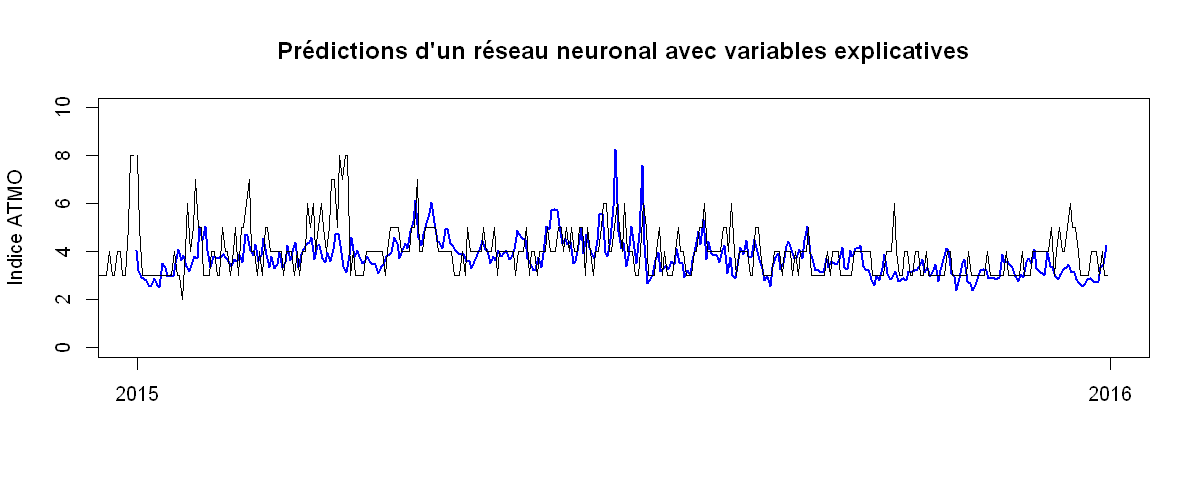

In [374]:
plot(fc_nn_365_reg, xlim=c(2015,2016), ylim=c(0,10), main="Prédictions d'un réseau neuronal avec variables explicatives", ylab="Indice ATMO", xaxt="n")
lines(Val$INDICE_ATMO_ts365)
axis(1, at=c(2014,2015,2016))

In [375]:
# Forecast accuracy measures
accuracy(f=fc_nn_365_reg, x=Val$INDICE_ATMO_ts365)

,ME,RMSE,MAE,MPE,MAPE,MASE,ACF1,Theil's U
Training set,0.001830774,0.01931006,0.01289763,0.02101311,0.3091895,0.01338211,0.004374978,NA
Test set,0.206634323,1.09307461,0.76700281,1.42017299,18.2224698,0.79581384,0.319091432,1.074377


# 7 Compare models' performances

In [376]:
models <- c("fc_365", 
          "fc_four5_365", 
          "fc_four30_365", 
          "fc_multi", 
          "fc_365_reg",
          "fc_multi_reg",
          "fc_nn_365", 
          "fc_nn_fourier30_365", 
          "fc_nn_multi",
          "fc_nn_365_reg")

In [377]:
dat_mod <- data.frame(models = models, 
                      RMSE = rep(NA,length(models)),
                      MAPE = rep(NA,length(models)),
                      Theil_s_U = rep(NA,length(models)))

for (mod in models) {
    error <- as.data.frame(accuracy(f=get(mod), x=Val$INDICE_ATMO_ts365))
    dat_mod[dat_mod$models == mod,"RMSE"] <- error$RMSE[2]
    dat_mod[dat_mod$models == mod,"MAE"] <- error$MAE[2]
    dat_mod[dat_mod$models == mod,"MAPE"] <- error$MAPE[2]
    dat_mod[dat_mod$models == mod,"Theil_s_U"] <- error[2,8]
   
    }

In [378]:
dat_mod[order(dat_mod$MAE),]

,models,RMSE,MAPE,Theil_s_U,MAE
1,fc_365,0.9899692,17.73434,1.009512,0.6989901
10,fc_nn_365_reg,1.0930746,18.22247,1.074377,0.7670028
8,fc_nn_fourier30_365,1.1019820,18.99546,1.110914,0.8027062
9,fc_nn_multi,1.1320730,20.19246,1.147388,0.8278547
2,fc_four5_365,1.0460721,23.02389,1.146827,0.8546219
4,fc_multi,1.0684936,23.40821,1.171424,0.8732383
6,fc_multi_reg,1.1743804,23.10911,1.226622,0.9011457
5,fc_365_reg,1.1786976,23.16011,1.231852,0.9020556
3,fc_four30_365,1.1080220,24.74555,1.232449,0.9141352
7,fc_nn_365,1.4977741,26.19829,1.489206,1.1675919


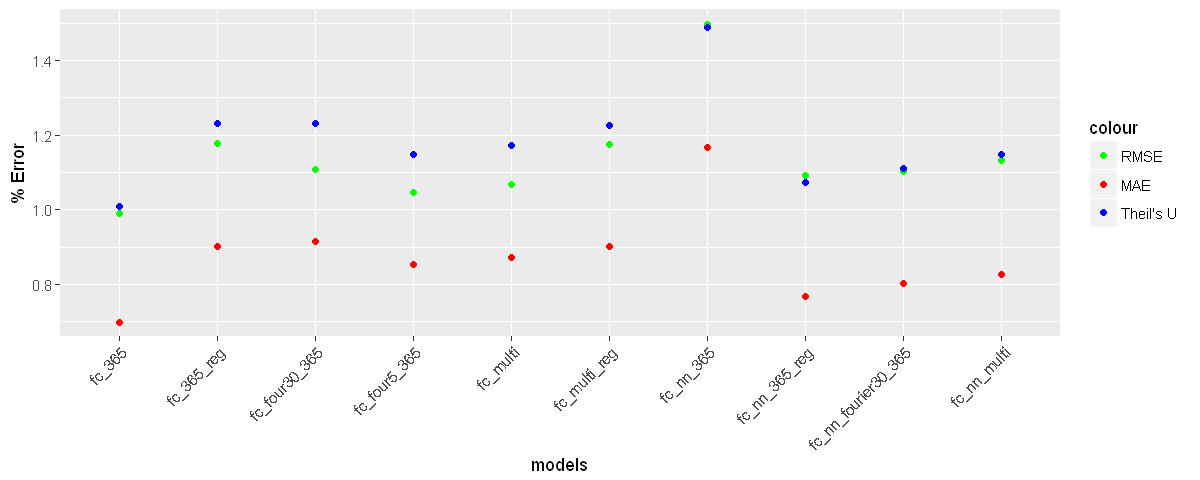

In [379]:
ggplot(data=dat_mod, aes(x = models)) + 
  geom_point(aes(y = RMSE, col="RMSE")) +
  geom_point(aes(y = MAE, col="MAE")) +
  geom_point(aes(y = Theil_s_U, col="Theil's U")) +
  scale_colour_manual(labels = c("RMSE", "MAE", "Theil's U"), 
                      breaks = c("RMSE", "MAE", "Theil's U"),
                      values = c("red", "green", "blue")) +
  ylab("% Error")+
  theme(axis.text.x = element_text(angle = 45, hjust = 1))

# 8 Walk Forward Validation

The neural network with external regressor seems to give the best results on the validation set. We will use it to perform a walk forward validation on the test set.
First, we will merge our previous training and validation sets to create our starting training set. Then, we will use a sliding window to predict pollution one week ahead in the test set.

In [380]:
dat_imp <- as.data.frame(apply(dat, 2, fun_miss))

In [381]:
dat_imp$DATE <- as.Date(dat_imp$DATE, format="%Y-%m-%d")

In [382]:
# Make the datasets correspond to weeks (start on Monday and end on Sunday)
dat_2 <- head(dat_imp,-6)    # Remove the first 6 days (Tuesday, Wednesday, Thursday, Friday, Saturday, Sunday)
dat_w <- tail(dat_2,-2)      # Remove the last 2 days (Monday, Tuesday)

INDICE_ATMO_ts365_w <- ts(dat_w$INDICE_ATMO, frequency=365.25, start=c(2005,as.numeric(format(dat_w$DATE[1], "%j"))))

In [383]:
n_days_test <- 366-6        # 366 (Test) minus the last 2 days that we have just removed from dat
n_days_Train <- 3652-6+365  # 3652 (Train) minus the first 6 days, plus 365 (Val)

In [384]:
n_weeks_test <- floor(364/7)

In [385]:
dat_mod <- data.frame(week = seq(1,52,1), 
                      RMSE = rep(NA,52),
                      MAPE = rep(NA,52),
                      Theil_s_U = rep(NA,52))

In [386]:
# Define the first week and last week
first_week <- 1
last_week <- 52

# Set delay between frames when replaying
oopt = ani.options(interval = 1, nmax = last_week, loop=0)

In [387]:
theme_ts <- theme(panel.border = element_rect(fill = NA, 
                                              colour = "grey10"),
                  panel.background = element_blank(),
                  panel.grid.minor = element_line(colour = "grey85"),
                  panel.grid.major = element_line(colour = "grey85"),
                  panel.grid.major.x = element_blank(),
                  panel.grid.minor.x = element_blank(),
                  axis.text = element_text(size = 13, face = "bold"),
                  axis.title = element_text(size = 15, face = "bold"),
                  plot.title = element_text(size = 16, face = "bold"),
                  strip.text = element_text(size = 16, face = "bold"),
                  strip.background = element_rect(colour = "black"),
                  legend.text = element_text(size = 15),
                  legend.title = element_text(size = 16, face = "bold"),
                  legend.background = element_rect(fill = "white"),
                  legend.key = element_rect(fill = "white"))

In [389]:
# Begin animation loop
makeplot <- function(){
 
    # Begin the loop that creates the individual graphs
    for(i in (first_week-1):(last_week-1)){
         
        # Split the dataset and create time series Train and Test objects from raw data (without NA)
        Train_365 <- ts(INDICE_ATMO_ts365_w[(i*7+1):(i*7+n_days_Train)], frequency=365.25, start=c(year(dat_w$DATE[i*7+1]), as.numeric(format(dat_w$DATE[i*7+1], "%j"))))   
        Test_365 <- ts(INDICE_ATMO_ts365_w[(n_days_Train+1+i*7):(n_days_Train+(i+1)*7)], frequency=365.25, start=c(year(dat_w$DATE[n_days_Train+1+i*7]),as.numeric(format(dat_w$DATE[n_days_Train+1+i*7], "%j"))))  # the next week
        
        # Split the dataset
        Train_df = dat_w[(i*7+1):(i*7+n_days_Train),]
        Test_df = dat_w[(n_days_Train+1+i*7):(n_days_Train+(i+1)*7),]    # the next week
        
        # Prepare matrix with external regressors
        Ext_reg <- subset(Train_df, select=c("month_2", "month_3", "month_4", "month_5", "month_6", "month_7", "month_8", "month_9", "month_10", "month_11", "month_12", "wind", "tempC", "humidity", "cloud", "pres", "rafper", "rain24", "weekday_dimanche", "weekday_jeudi", "weekday_mardi", "weekday_mercredi", "weekday_samedi", "weekday_vendredi", "holidays", "goReturnHolidays")) 
        Ext_regf <- subset(Test_df,select=c("month_2", "month_3", "month_4", "month_5", "month_6", "month_7", "month_8", "month_9", "month_10", "month_11", "month_12", "wind", "tempC", "humidity", "cloud", "pres", "rafper", "rain24", "weekday_dimanche", "weekday_jeudi", "weekday_mardi", "weekday_mercredi", "weekday_samedi", "weekday_vendredi", "holidays", "goReturnHolidays"))
        
        Ext_reg_mat <- data.matrix(Ext_reg)
        Ext_regf_mat <- data.matrix(Ext_regf)
       
        # Fit model
        fit_roll <- nnetar(Train_365, P = 1, repeats = 20, lambda= BoxCox.lambda(Train_365), xreg=Ext_reg_mat, MaxNWts=7500)
        
        # Forecast
        fc_roll <- forecast(fit_roll, h=7, xreg=Ext_regf_mat)
        
        # Measure errors
        error <- as.data.frame(accuracy(f=fc_roll, x=Test_365))
        rmse <- error$RMSE[2]
        dat_mod[i+1,"RMSE"] <- error$RMSE[2]
        dat_mod[i+1,"MAE"] <- error$MAE[2]
        dat_mod[i+1,"MAPE"] <- error$MAPE[2]
        dat_mod[i+1,"Theil_s_U"] <- error[2,8]

        # Create a shorter dataframe for plot
        Train_df_short <- tail(Train_df, 52*5)
  
        # Create a dataframe to make the plot
        data_for <- data.table(INDICE_ATMO = c(Train_df_short$INDICE_ATMO, Test_df$INDICE_ATMO, fc_roll$mean),
                       Date = c(Train_df_short$DATE, rep(Test_df$DATE, 2)),
                       Type = c(rep("Train data", nrow(Train_df_short)),
                                rep("Test data", nrow(Test_df)),
                                rep("Forecast", nrow(Test_df))))
        
        # Make plot
        print(ggplot(data_for, aes(Date, INDICE_ATMO, color = Type)) +
          geom_line(size = 0.8, alpha = 0.75) +
          facet_zoom(x = Date %in% Test_df$DATE, zoom.size = 1.2) +
          labs(x= NULL, title =  paste("Forecast from FNN; ", "week: ", i, "; RMSE: ",
               round(rmse, 2), "%", sep = "")) +
          theme_ts)
        ani.pause()
    }
}

saveGIF(makeplot(), movie.name = "plot_nn_animation_2016_week.gif")

Executing: 
"convert -loop 0 -delay 100 Rplot1.png Rplot2.png Rplot3.png
    Rplot4.png Rplot5.png Rplot6.png Rplot7.png Rplot8.png Rplot9.png
    Rplot10.png Rplot11.png Rplot12.png Rplot13.png Rplot14.png
    Rplot15.png Rplot16.png Rplot17.png Rplot18.png Rplot19.png
    Rplot20.png Rplot21.png Rplot22.png Rplot23.png Rplot24.png
    Rplot25.png Rplot26.png Rplot27.png Rplot28.png Rplot29.png
    Rplot30.png Rplot31.png Rplot32.png Rplot33.png Rplot34.png
    Rplot35.png Rplot36.png Rplot37.png Rplot38.png Rplot39.png
    Rplot40.png Rplot41.png Rplot42.png Rplot43.png Rplot44.png
    Rplot45.png Rplot46.png Rplot47.png Rplot48.png Rplot49.png
    Rplot50.png Rplot51.png Rplot52.png
    "plot_nn_animation_2016_week.gif""
Output at: plot_nn_animation_2016_week.gif


[1] TRUE

# 9 Going further

* Select the best external regressors